# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring</span>

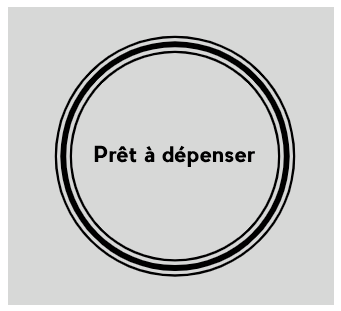

 # <span class='bg-primary'>P7_01_03 - PRE PROCESSING</span>

Ce notebook traite du pré processing des jeux de données :

- **bureau.csv**,
- **bureau_balance.csv**,
- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

En particulier :

- **Nettoyage** :
    - **optimisation de la mémoire** en modifiant le type des données. 
    - correction des **valeurs aberrantes**.
    - **imputation** des valeurs manquantes
- **Feature engineering** : dans cette section, nous allons commencer par utiliser les connaissances et les connaissances acquises lors de l'analyse exploratoire des données pour obtenir de bons ensembles de variables en utilisant le feature engineering. Il convient de noter que la plupart des varaibles générées sont basées sur la connaissance du domaine et les expérimentations. Sans de bons ensembles de variibles, les algorithmes d'apprentissage automatique ne peuvent pas produire de résultats efficaces. Nous devrons donc trouver des moyens ingénieux de faire de l'ingénierie des caractéristiques pour que le modèle prenne de meilleures décisions. 
- **Feature selection** : outre la génération de caractéristiques importantes/utiles, il est également essentiel de supprimer les caractéristiques redondantes et bruyantes. Si nous introduisons des déchets/bruits dans notre modèle d'apprentissage automatique, il retournera des déchets/bruits. Nous devons donc trouver de bonnes techniques de sélection des caractéristiques.
- **Aggregation** : avec les données principales de Home Crédit Group.

***
Sources
***
Les fonctions d'aggrégation ont été reprises du notebook : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output) en adaptant la signature pour transmettre le prefix du nom des colonnes et pouvoir passer un dictionnaire des statistiques qu'on souhaite ajouter.

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [59]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

Le **Kernel Kaggle** utilisé pour l'analyse exploratoire ayant l'EDA le plus de commentaires et effectuant une analyse exploratoire complète sur toutes les fichiers csv mis à notre disposition a été livré par **Rishabh Rao** (Student at -Jaipur, Rajasthan, India).
- [Kernel Kaggle Rishabh Rao](https://www.kaggle.com/rishabhrao/home-credit-default-risk-extensive-eda)

Ce travail est complété par l'auteur par une présentation sur le site medium.com :
[Explications](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)

Les fonctions python utilisées pour l'EDA sont extraites du [github](https://github.com/rishabhrao1997/Home-Credit-Default-Risk) et stockées dans la librairie *EDA_KERNEL_FONCTIONS.py*.

In [28]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import jyquickhelper
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
import outils_data
import outils_visu
import outils_preprocessing
import eda_kernel_fonctions
import verstack
from verstack import NaNImputer
import pickle
# Encodage variables catégorielles
from sklearn.preprocessing import LabelEncoder
# import phik
# Plotly
# import plotly
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# Warnings
warnings.filterwarnings('ignore')
# plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + matplotlib.__version__)
print('Verstack              : ' + verstack.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils visualisation  : ' + outils_visu.__version__)
print('Outils pré-processing : ' + outils_preprocessing.__version__)
print('EDA KERNEL KAGGLE     : ' + eda_kernel_fonctions.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic
Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.4
Matplotlib            : 3.3.4
Verstack              : 0.3.1
Outils dataframe      : 0.0.4
Outils visualisation  : 0.0.2
Outils pré-processing : 0.0.0
EDA KERNEL KAGGLE     : 0.0.0
Lancé le           : 2021-07-22T14:47:26.888338


In [29]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Chargement des jeux de données</span>

In [30]:
# Répertoire de stockages des fichiers mis à notre disposition
path = '../data/'

**Chargement des fichiers**

In [31]:
application_train, application_test, bureau, bureau_balance, cc_balance, \
    installments_payments, POS_CASH_balance, previous_application, \
    HomeCredit_columns_description = \
    eda_kernel_fonctions.load_all_tables(path)

Chargement des jeux de donnees...
--------------------------------------------------------------------
Fichier application_train.csv chargé -> dataframe : application_train
Fichier application_test.csv chargé -> dataframe : application_test
Fichier bureau.csv chargé -> dataframe : bureau
Fichier bureau_balance.csv chargé -> dataframe : bureau_balance
Fichier credit_card_balance.csv chargé -> dataframe : cc_balance
Fichier installments_payments.csv chargé -> dataframe : installments_payments
Fichier POS_CASH_balance.csv chargé -> dataframe : POS_CASH_balance
Fichier HomeCredit_columns_description.csv chargé -> dataframe : HomeCredit_columns_description
Fichier previous_application.csv chargé -> dataframe : previous_application
--------------------------------------------------------------------
Chargement des 9 jeux de donnees terminée en 0:00:29.594689 secondes


In [32]:
# Sauvegarde des dataframes
application_train_sav = application_train.copy()
application_test_sav = application_test.copy()
bureau_sav = bureau.copy()
bureau_balance_sav = bureau_balance.copy()
cc_balance_sav = cc_balance.copy()
installments_payments_sav = installments_payments.copy()
POS_CASH_balance_sav = POS_CASH_balance.copy()
previous_application_sav = previous_application.copy()

## <span style='background:Thistle'>3. Données du train et du test set</span>

| Fichier | Description |
| --- | --- |
| <p style='text-align: justify;'>**application_train.csv** <br> **application_test.csv**</p> | <ul style='text-align: justify;'><li>Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).</li> <li>Données statiques pour toutes les applications.</li><li>Une ligne représente un prêt dans notre échantillon de données.</li></ul> |

### <span style='background:PowderBlue'>3.1. Fichiers application_train.csv</span>

In [7]:
# Taille : nombre de lignes/colonnes
nRow, nVar = application_train.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 307511 lignes et 122 variables.


In [8]:
# Variables quantitatives
cols_num = application_train.select_dtypes(include=[np.number]).columns \
    .to_list()

In [9]:
# Variables catégorielles
cols_cat = application_train.select_dtypes(exclude=[np.number]).columns \
    .to_list()

#### <span style='background:Moccasin'>3.1.1. Types des objets</span>

Amélioration de la mémoire en réduisant la taille des objets.

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


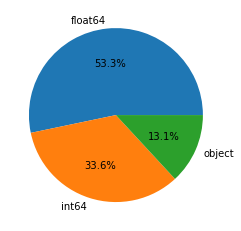

In [10]:
# Types des variables
outils_data.get_types_variables(application_train, True, False, True)

In [11]:
application_train =\
    outils_preprocessing.reduce_mem_usage(application_train, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 286.23 MB
Memory usage après optimization: 92.38 MB
Diminution de 67.7%
-------------------------------------------------------------------------------


In [12]:
# Modification à la main : REGION_RATING_CLIENT contient 1, 2 ou 3
# ==> object
application_train['REGION_RATING_CLIENT'] = \
    application_train['REGION_RATING_CLIENT'].astype('object')
# Modification à la main : REGION_RATING_CLIENT_W_CITY contient
# ==> 1, 2 ou 3 object
application_train['REGION_RATING_CLIENT_W_CITY'] = \
    application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')

In [13]:
# EMERGENCYSTATE_MODE contient Yes/No ==> transformer en 1/0
%pycodestyle_off
dico_emergency = {'Yes' : 0,
                  'No' : 1,
                  np.nan : 0}
outils_data.traduire_valeurs_variable(application_train,
                                      'EMERGENCYSTATE_MODE', dico_emergency)
application_train['EMERGENCYSTATE_MODE'] = \
    application_train['EMERGENCYSTATE_MODE'].astype('int8')
%pycodestyle_on

In [14]:
# FLAG_OWN_CAR contient Y/N ==> transformer en 1/0
%pycodestyle_off
dico_owncar = {'Y' : 0,
               'N' : 1,
               np.nan : 0}
outils_data.traduire_valeurs_variable(application_train, 'FLAG_OWN_CAR',
                                      dico_owncar)
application_train['FLAG_OWN_CAR'] = \
    application_train['FLAG_OWN_CAR'].astype('int8')
application_train['FLAG_OWN_CAR'].unique()
%pycodestyle_on

In [15]:
# FLAG_OWN_REALTY contient Y/N ==> transformer en 1/0
%pycodestyle_off
dico_ownreal = {'Y' : 0,
                'N' : 1,
                np.nan : 0}
outils_data.traduire_valeurs_variable(application_train, 'FLAG_OWN_REALTY',
                                      dico_ownreal)
application_train['FLAG_OWN_REALTY'] = \
    application_train['FLAG_OWN_REALTY'].astype('int8')
application_train['FLAG_OWN_REALTY'].unique()
%pycodestyle_on

In [16]:
application_train['FLAG_OWN_REALTY'].unique()

array([0, 1], dtype=int8)

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                        int32
TARGET                             int8
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                       int8
FLAG_OWN_REALTY                    int8
CNT_CHILDREN                       int8
AMT_INCOME_TOTAL                float32
AMT_CREDIT                      float32
AMT_ANNUITY                     float32
AMT_GOODS_PRICE                 float32
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float16
DAYS_BIRTH                        int16
DAYS_EMPLOYED                     int32
DAYS_REGISTRATION               float16
DAYS_ID_PUBLISH                   int16
OWN_CAR_AGE                     float16
FLAG_MOBIL                         int8
FLAG_EMP_PHONE                     int8
FLAG_WORK_PHONE                    int8


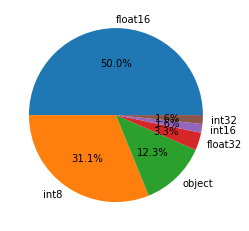

In [17]:
# Types des variables
outils_data.get_types_variables(application_train, True, False, True)

#### <span style='background:Moccasin'>3.1.2. Valeurs aberrantes</span>

Correction des valeurs aberrantes détectées lors de l'EDA.

**DAYS_EMPLOYED**

A partir du percentile 90, la valeur est 365243 jours donc 1000 ans !

In [18]:
# Nombre de ligne erronées
nb_err = \
    application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                       == 365243].count()
pourc_err = round((nb_err*100)/application_train.shape[0], 2)
print(f'Nombre d\'erreurs DAYS_EMPLOYED : {nb_err} ({pourc_err}%)')

Nombre d'erreurs DAYS_EMPLOYED : 55374 (18.01%)


In [19]:
# Correction
application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                   == 365243] = np.nan

In [20]:
# TODO : POURQUOI 30?
# OBS Columns have an erroneous value, we'll remove those values
# application_train['OBS_30_CNT_SOCIAL_CIRCLE']
#  [application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
# application_train['OBS_60_CNT_SOCIAL_CIRCLE']
# [application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan

#### <span style='background:Moccasin'>3.1.3. Comparaison variables catégorielles du train set et du test set</span>

In [21]:
%pycodestyle_off
for var in cols_cat :
    var_train = application_train[var].unique()
    var_test = application_test[var].unique()
    diff = [val for val in var_train if val not in var_test]
    if len(diff) > 0 and diff != 'nan':
        print(f'Variable {var} - catégories différentes : {diff}')
%pycodestyle_on        

Variable CODE_GENDER - catégories différentes : ['XNA']
Variable FLAG_OWN_CAR - catégories différentes : [1, 0]
Variable FLAG_OWN_REALTY - catégories différentes : [0, 1]
Variable NAME_TYPE_SUITE - catégories différentes : [nan]
Variable NAME_INCOME_TYPE - catégories différentes : ['Maternity leave']
Variable NAME_FAMILY_STATUS - catégories différentes : ['Unknown']
Variable OCCUPATION_TYPE - catégories différentes : [nan]
Variable FONDKAPREMONT_MODE - catégories différentes : [nan]
Variable HOUSETYPE_MODE - catégories différentes : [nan]
Variable WALLSMATERIAL_MODE - catégories différentes : [nan]
Variable EMERGENCYSTATE_MODE - catégories différentes : [1, 0]


**CODE_GENDER**

In [22]:
# Nombre de lignes ayant la valeur 'XNA' ?
application_train[application_train['CODE_GENDER'] ==
                  'XNA']['CODE_GENDER'].count()

4

In [23]:
# Correction : difficile d'imputer le sexe par le mode de cette catégorie
# Comme il n'y a que 4 clients avec un sexe non renseigné, on supprime ces
# valeurs
application_train = \
    application_train[application_train['CODE_GENDER'] != 'XNA']

**NAME_INCOME_TYPE**

In [24]:
# Nombre de lignes ayant la valeur 'XNA' ?
application_train[application_train['NAME_INCOME_TYPE'] ==
                  'Maternity leave']['NAME_INCOME_TYPE'].count()

5

In [25]:
# Correction : remplacer 'Maternity leave' par np.nan
application_train['NAME_INCOME_TYPE'] = \
    [row if row != 'Maternity leave' else np.nan for row in
     application_train['NAME_INCOME_TYPE']]
# Vérification
application_train[application_train['NAME_INCOME_TYPE'] ==
                  'Maternity leave']['NAME_INCOME_TYPE'].count()

0

**NAME_FAMILY_STATUS**

In [26]:
# Nombre de lignes ayant la valeur 'Maternity leave' ?
application_train[application_train['NAME_FAMILY_STATUS'] ==
                  'Unknown']['NAME_FAMILY_STATUS'].count()

2

In [27]:
# Correction : remplacer 'Unknown' par np.nan
application_train['NAME_FAMILY_STATUS'] = \
    [row if row != 'Unknown' else np.nan for row in
     application_train['NAME_FAMILY_STATUS']]
# Vérification
application_train[application_train['NAME_FAMILY_STATUS'] ==
                  'Unknown']['NAME_FAMILY_STATUS'].count()

0

#### <span style='background:Moccasin'>3.1.4. Valeurs manquantes</span>

In [28]:
# Valeurs manquantes du dataframe
df_nan_applitrain = outils_data.get_missing_values(application_train,
                                                   True, False, True)

Valeurs manquantes : 9062014 NaN pour 37515854 données (24.16 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
COMMONAREA_AVG,214862,69.8700
COMMONAREA_MODE,214862,69.8700
COMMONAREA_MEDI,214862,69.8700
NONLIVINGAPARTMENTS_MODE,213512,69.4300
NONLIVINGAPARTMENTS_MEDI,213512,69.4300
NONLIVINGAPARTMENTS_AVG,213512,69.4300
FONDKAPREMONT_MODE,210293,68.3900
LIVINGAPARTMENTS_MODE,210197,68.3600
LIVINGAPARTMENTS_MEDI,210197,68.3600
LIVINGAPARTMENTS_AVG,210197,68.3600


- Parmi les variables importantes repérées lors de l'analyse exploratoire pour départager les non-défaillants des défaillants, la variable FLOORSMIN_AVG est celle qui a le plus de valeurs manquantes (67.85%).
- On fixera le seuil de suppression des variables ayant de nombreuses valeurs manquantes à 68%.

In [29]:
# Liste des variables ayant plus de 68% de valeurs manquantes
cols_nan_a_suppr = \
    df_nan_applitrain[df_nan_applitrain['% de valeurs manquantes'] > 68] \
    .index.to_list()
print(f'Nombre de variables à supprimer : {len(cols_nan_a_suppr)}')
cols_nan_a_suppr

Nombre de variables à supprimer : 10


['COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE']

In [30]:
# Suppression des variables avec un seuil de nan > 68%
application_train.drop(columns=cols_nan_a_suppr, inplace=True)
# Variables catégorielles
cols_cat = application_train.select_dtypes(exclude=[np.number]).columns \
    .to_list()
# Variables quantitatives
cols_num = application_train.select_dtypes(include=[np.number]).columns \
    .to_list()
# Taille : nombre de lignes/colonnes
nRow, nVar = application_train.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 307507 lignes et 112 variables.


#### <span style='background:Moccasin'>3.1.5. Imputation</span>

In [31]:
# Variables quantitatives - imputation par 0
appli_train_imp1 = application_train.copy()
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
appli_train_imp2 = application_train.copy()

**Variables quantitatives**

- Lors de l'analyse exploratoire, nous avons pu observer que les valeurs non renseignées peuvent donner des indications. Le demandeur a pu ne pas donner le renseignement pour éviter d'avoir un refus à sa demande.
- Nous **imputerons** donc les valeurs manquantes des **variables quantitatives** par la valeur **médiane** de chacune de ces variables puisque nous avons découvert lors de l'analyse exploratoire qu'il y avait de nombreux outliers.

In [32]:
# TODO :
# Imputation :  toutes les variables par 0? ou le mode? ou NaNImputer?
# Est-ce que je fais plusieurs tests?

**Imputation par median** 

In [33]:
# Variables quantitatives - imputation par médiane
nb_nan_median = application_train[cols_num].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
application_train.fillna(application_train[cols_num].median(), inplace=True)
# Vérification
nb_nan_median = application_train[cols_num].isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 6527684
Nombre de nan après imputation par median : 0


**Imputation par une constante 0** 

In [34]:
# Variables quantitatives - imputation par 0
nb_nan_zero = appli_train_imp1[cols_num].isna().sum().sum()
print(f'Nombre de nan avant imputation par 0 : {nb_nan_zero}')
appli_train_imp1[cols_num] = appli_train_imp1[cols_num].fillna(0)
# Vérification
nb_nan_zero = appli_train_imp1[cols_num].isna().sum().sum()
print(f'Nombre de nan après imputation par 0 : {nb_nan_zero}')

Nombre de nan avant imputation par 0 : 6527684
Nombre de nan après imputation par 0 : 0


**Imputation avec NaNIMputer (Verstack)**

*Note*: [Source](https://medium.com/swlh/impute-missing-values-the-right-way-c63735fccccd)

In [35]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = appli_train_imp2[cols_num].isna().sum().sum()

In [36]:
# Copie du jeu de données
df_nan = appli_train_imp2.copy()
X_nan = df_nan[cols_num]

In [37]:
# !pip install verstack pour l'installation
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


Dataset dimensions:
 - rows:         307507
 - columns:      98
 - mb in memory: 53.37
 - NaN cols num: 53
--------------------------

Deploy multiprocessing with 12 parallel proceses


NaNs imputation time: 6.74 minutes
--------------------------------------------------


In [38]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
appli_train_imp2[cols_num] = df_tmp_nan[cols_num]
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = appli_train_imp2[cols_num].isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 6527684
Nombre de nan après imputation par NaNImputer : 0


In [39]:
fic_sav_appl2 = '../sauvegarde/pre-processing/appli_train_imp2.pickle'

In [40]:
# Sauvegarde de appli_train_imp2
with open(fic_sav_appl2, 'wb') as f:
    pickle.dump(appli_train_imp2, f, pickle.HIGHEST_PROTOCOL)

**Variable qualitatives**

- Lors de l'analyse exploratoire, nous avons pu observer que les valeurs non renseignées peuvent donner des indications. Le demandeur a pu ne pas donner le renseignement pour éviter d'avoir un refus à sa demande.
- Nous imputerons donc les valeurs manquantes des variables qualitatives par la valeur mode de chacune de ces variables.

In [41]:
# TODO :
# Imputation :  toutes les variables par XNA? par mode?
# Est-ce que je fais plusieurs tests?

**Imputation par le mode de la catégorie**

In [42]:
# Variables qualitatives - imputation par mode de la variable
nb_nan_cat = application_train[cols_cat].isna().sum().sum()
print(f'Nombre de nan avant imputation par mode : {nb_nan_cat}')
for var in cols_cat:
    mode = application_train[var].mode()[0]
    application_train[var].fillna(mode, inplace=True)
nb_nan_cat = application_train[cols_cat].isna().sum().sum()
print(f'Nombre de nan après imputation par mode : {nb_nan_cat}')

Nombre de nan avant imputation par mode : 408324
Nombre de nan après imputation par mode : 0


**Imputation par une constante XNA**

In [43]:
# Variables quantitatives - imputation par XNA
%pycodestyle_off
nb_nan_xna = appli_train_imp1[cols_cat].isna().sum().sum()
print(f'Nombre de nan avant imputation par XNA : {nb_nan_xna}')
for var in cols_cat :
    appli_train_imp1[var] = appli_train_imp1[var].fillna('XNA')
# Vérification
nb_nan_xna = appli_train_imp1[cols_cat].isna().sum().sum()
print(f'Nombre de nan après imputation par XNA : {nb_nan_xna}')
%pycodestyle_on

Nombre de nan avant imputation par XNA : 408324
Nombre de nan après imputation par XNA : 0


In [44]:
# Variables quantitatives - imputation par XNA
%pycodestyle_off
nb_nan_xna2 = appli_train_imp2[cols_cat].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_xna2}')
for var in cols_cat :
    appli_train_imp2[var] = appli_train_imp2[var].fillna('XNA')
# Vérification
nb_nan_xna2 = appli_train_imp2[cols_cat].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_xna2}')
%pycodestyle_on

Nombre de nan avant imputation par median : 408324
Nombre de nan avant imputation par median : 0


**Bilan**:
- application_train : 
    - variables quantitatives imputées par median.
    - variables qualitatives imputées par mode.
- appli_train_imp1 :
    - variables quantitatives imputées par la constante 0.
    - variables qualitatives imputées par la constante XNA.
- appli_train_imp2 :
    - variables quantitatives imputées par NaNImputer.
    - variables qualitatives imputées par la constante XNA.

In [45]:
# Vérification : plus de nan
# Valeurs manquantes du dataframe application_train
print(f'Nombre nan application_train : {application_train.isna().sum().sum()}')
# Sauvegarde de application_train
fic_sav_appltrain_sansnan = \
    '../sauvegarde/pre-processing/application_train_sans_nan.pickle'
with open(fic_sav_appltrain_sansnan, 'wb') as f:
    pickle.dump(application_train, f, pickle.HIGHEST_PROTOCOL)
# Valeurs manquantes du dataframe appli_train_imp1
print(f'Nombre nan appli_train_imp1 : {appli_train_imp1.isna().sum().sum()}')
# Sauvegarde de appli_train_imp1
fic_sav_appltrainimp1_sansnan = \
    '../sauvegarde/pre-processing/appli_train_imp1_sans_nan.pickle'
with open(fic_sav_appltrainimp1_sansnan, 'wb') as f:
    pickle.dump(appli_train_imp1, f, pickle.HIGHEST_PROTOCOL)
# Valeurs manquantes du dataframe appli_train_imp2
print(f'Nombre nan appli_train_imp2 : {appli_train_imp2.isna().sum().sum()}')
# Sauvegarde de appli_train_imp2
fic_sav_appltrainimp2_sansnan = \
    '../sauvegarde/pre-processing/appli_train_imp2_sans_nan.pickle'
with open(fic_sav_appltrainimp2_sansnan, 'wb') as f:
    pickle.dump(appli_train_imp2, f, pickle.HIGHEST_PROTOCOL)

Nombre nan application_train : 0
Nombre nan appli_train_imp1 : 0
Nombre nan appli_train_imp2 : 0


#### <span style='background:Moccasin'>3.1.6. Feature engineering</span>

**Variables métiers & automatiques (mean, max...)**

In [46]:
# Feature engineering pour le dataframe application_train
application_train = \
    outils_preprocessing.feature_engineering_application(application_train)
application_train.shape

(307507, 170)

In [47]:
# Feature engineering pour le dataframe appli_train_imp1
appli_train_imp1 = \
    outils_preprocessing.feature_engineering_application(appli_train_imp1)
appli_train_imp1.shape

(307507, 170)

In [48]:
# Feature engineering pour le dataframe appli_train_imp2
appli_train_imp2 = \
    outils_preprocessing.feature_engineering_application(appli_train_imp2)
appli_train_imp2.shape

(307507, 170)

**Super variable du gagnant du concours Kaggle**

In [49]:
# TODO : voir si on utilise car d'après soutenance pas explicable?

- Imputation de la moyenne des 500 valeurs cibles des voisins les plus proches pour chaque application du train set ou test set.
- Les voisins sont calculés en utilisant :
    - les variables très importantes :
        - EXT_SOURCE-1, 
        - EXT_SOURCE_2 
        - et EXT_SOURCE_3,
    - et CREDIT_ANNUITY_RATIO (ratio du Montant du crédit du prêt / Annuité de prêt).
[Source](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821)    

In [50]:
# Feature engineering super variable pour le dataframe application_train
outils_preprocessing. \
    feature_engineering_neighbors_EXT_SOURCE(application_train)
application_train.shape

(307507, 171)

In [51]:
# Feature engineering super variable pour le dataframe appli_train_imp1
outils_preprocessing. \
    feature_engineering_neighbors_EXT_SOURCE(appli_train_imp1)
appli_train_imp1.shape

(307507, 171)

In [52]:
# Feature engineering super variable pour le dataframe appli_train_imp2
outils_preprocessing. \
    feature_engineering_neighbors_EXT_SOURCE(appli_train_imp2)
appli_train_imp2.shape

(307507, 171)

#### <span style='background:Moccasin'>3.1.7. Encodage des variables qualitatives</span>

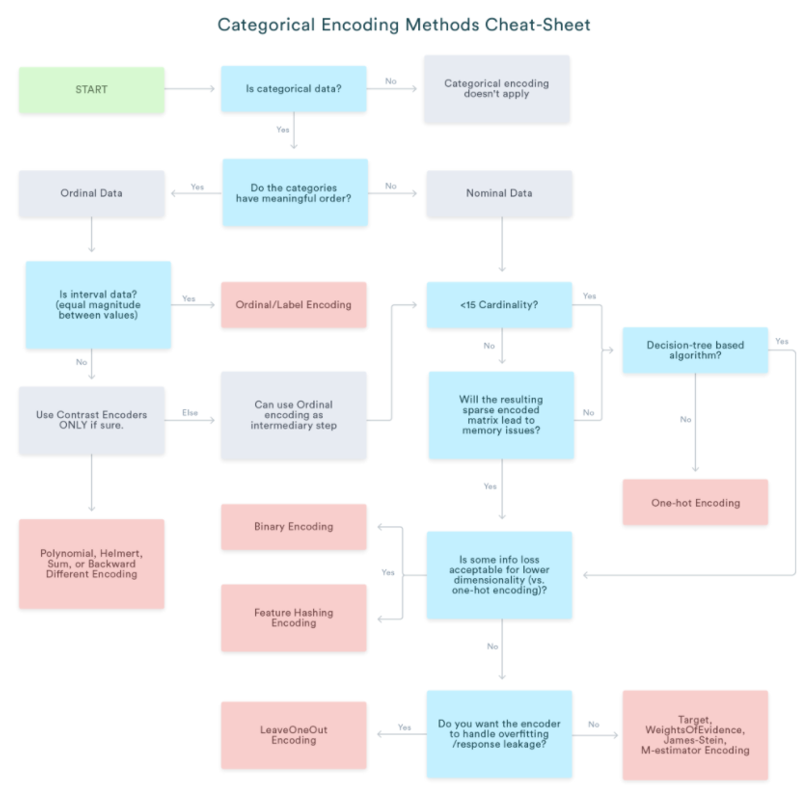

In [53]:
# Liste des variables catégorielles
cols_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [54]:
# Résumé des variables qualitatives
desc_cat = outils_data.description_variables(application_train, 'cat')
desc_cat

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,HOUSETYPE_MODE,WALLSMATERIAL_MODE
type,object,object,object,object,object,object,object,object,object,object,object,object
nb_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,307507,307507,307507,307507,307507,307507,307507,307507,307507,307507,307507,307507
unique,2,2,7,7,5,5,6,18,7,58,3,7
top,Cash loans,F,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,block of flats,Panel
freq,278232,202448,249815,158776,218389,196431,272865,151575,53900,67992,304796,222379


In [55]:
# Variables avec 2 catégories uniques
%pycodestyle_off
df_tmp = pd.DataFrame(desc_cat.loc['unique', :] <= 2)
liste_2cat = df_tmp[df_tmp['unique'] == True].index.to_list()
%pycodestyle_on
liste_2cat

['NAME_CONTRACT_TYPE', 'CODE_GENDER']

In [56]:
# Variables avec plus de 15 catégories uniques
%pycodestyle_off
df_tmp2 = pd.DataFrame(desc_cat.loc['unique', :] > 15)
liste_catsup15 = df_tmp2[df_tmp2['unique'] == True].index.to_list()
%pycodestyle_on
liste_catsup15

['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

**Bilan** :
- 2 variables ne contiennent que 2 catégories, on encodera ces varaibles avec LabelEncoder :
    - 'NAME_CONTRACT_TYPE',
    - et 'CODE_GENDER'.
- 2 variables avec plus de 15 catégories, on tentera d'encoder avec OneHotEncoder dans un premier temps et si on a des problèmes mémoires avec TargetEncoder :
    - 'OCCUPATION_TYPE', 
    - et 'ORGANIZATION_TYPE'.

**LabelEncoder**

Les 2 variables qualitatives avec seulement 2 types de catégories seront imputées avec LabelEncoder.

In [57]:
%pycodestyle_off
le = LabelEncoder()
for var in liste_2cat:
    # Dataframe application_train
    le.fit(application_train[var])
    application_train[var] = le.transform(application_train[var])
    # Dataframe appli_train_imp1
    le.fit(appli_train_imp1[var])
    appli_train_imp1[var] = le.transform(appli_train_imp1[var])
    # Dataframe appli_train_imp2
    le.fit(appli_train_imp2[var])
    appli_train_imp2[var] = le.transform(appli_train_imp2[var])
%pycodestyle_on

**Bilan** :
- Variable CODE_GENDER :
    - 0 : Feminin
    - 1 : Masculin
- Variable CODE_GENDER :
    - 0 : Cash loans
    - 1 : Revolving loans 

**OneHotEncoder**

Les variables qualitatives avec plus de 2 catégories seront encodées avec OneHotEncoder.

In [58]:
# Onehot encoding pour le reste des variables
# Dataframe application_train
application_train = pd.get_dummies(application_train)
print(f'application_train : {application_train.shape}')
# Dataframe appli_train_imp1
appli_train_imp1 = pd.get_dummies(appli_train_imp1)
print(f'appli_train_imp1 : {appli_train_imp1.shape}')
# Dataframe appli_train_imp2
appli_train_imp2 = pd.get_dummies(appli_train_imp2)
print(f'appli_train_imp2 : {appli_train_imp2.shape}')

application_train : (307507, 284)
appli_train_imp1 : (307507, 290)
application_appli_train_imp2train : (307507, 290)


In [59]:
# Variables en plus?
list1 = set(application_train.columns.to_list())
list2 = set(appli_train_imp1 .columns.to_list())
list2 ^ list1

{'HOUSETYPE_MODE_XNA',
 'NAME_FAMILY_STATUS_XNA',
 'NAME_INCOME_TYPE_XNA',
 'NAME_TYPE_SUITE_XNA',
 'OCCUPATION_TYPE_XNA',
 'WALLSMATERIAL_MODE_XNA'}

#### <span style='background:Moccasin'>3.1.8. Gestion des fortes corrélations</span>

**application_train**

In [60]:
# Réduction de la mémoire pour les nouvelles variables
application_train =\
    outils_preprocessing.reduce_mem_usage(application_train, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 187.39 MB
Memory usage après optimization: 166.87 MB
Diminution de 11.0%
-------------------------------------------------------------------------------


In [61]:
# Types des variables
outils_data.get_types_variables(application_train, True, True, False)

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                                             int32
TARGET                                                  int8
NAME_CONTRACT_TYPE                                      int8
CODE_GENDER                                             int8
FLAG_OWN_CAR                                            int8
FLAG_OWN_REALTY                                         int8
CNT_CHILDREN                                            int8
AMT_INCOME_TOTAL                                     float32
AMT_CREDIT                                           float32
AMT_ANNUITY                                          float32
AMT_GOODS_PRICE                                      float32
REGION_POPULATION_RELATIVE                           float16
DAYS_BIRTH                                             int16
DAYS_EMPLOYED                                        float16
DAYS_REGISTRATION                                    float16
DAYS_ID_PUBLISH                                        int16
OWN_CAR_AGE             

,Nombre par type de variable,% des types de variable
float16,215,75.7000
int8,47,16.5500
float32,19,6.6900
int16,2,0.7000
int32,1,0.3500


In [62]:
# Préparation de la matrice de corrélation
# ---------------------------------------------------------------------
# Variables fortement corrélées : si le coef de Pearson est :
# > 0.8 ou < -0.8
# et inférieur à 1 ou > -1 (corrélée avec elle-même)
seuil = 0.8
# Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
# les corrélations positives et négatives séparément
corr = application_train.corr().abs()
# On ne conserve que la partie supérieur à la diagonale pour n'avoir
# qu'une seule fois les corrélations prisent en compte (symétrie axiale)
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

In [63]:
# Variables avec un coef de Pearson > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables fortement corrélées à supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

78 variables fortement corrélées à supprimer :

AMT_GOODS_PRICE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT_W_CITY
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
ELEVATORS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAREA_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAREA_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
INCOME_ANNUITY_DIFF
INCOME_AGE_RATIO
CREDIT_AGE_RATIO
CREDIT_EXT_RATIO
HOUR_PROCESS_CREDIT_MUL
YEARS_BIRTH
AGE_EMPLOYED_DIFF
EMPLOYED_AGE_RATIO
LAST_PHONE_BIRTH_RATIO
CAR_EMPLOYED_DIFF
CAR_AGE_DIFF
CAR_AGE_RATIO
CHILDREN_INCOME_RATIO
PER_CAPITA_INCOME
REGIONS_INCOME_MOY
REGION_RATING_MAX
REGION_RATING_MEAN
REGION_RATING_MUL
FLAG_REGIONS_SUM
EXT_SOURCE_MEAN
EXT_SOURC

In [64]:
# Suppression des variables fortement corrélées
print(f'application_train : {application_train.shape}')
application_train.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train : {application_train.shape}')

application_train : (307507, 284)
application_train : (307507, 206)


In [65]:
# Sauvegarde de application_train nettoyée, encodée, prête pour ML
fic_sav_application_train = \
    '../sauvegarde/pre-processing/application_train_clean.pickle'
with open(fic_sav_application_train, 'wb') as f:
    pickle.dump(application_train, f, pickle.HIGHEST_PROTOCOL)

**appli_train_imp1**

In [66]:
# Réduction de la mémoire pour les nouvelles variables
appli_train_imp1 =\
    outils_preprocessing.reduce_mem_usage(appli_train_imp1, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 189.15 MB
Memory usage après optimization: 173.32 MB
Diminution de 8.4%
-------------------------------------------------------------------------------


In [67]:
# Types des variables
outils_data.get_types_variables(appli_train_imp1, True, True, False)

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                                             int32
TARGET                                                  int8
NAME_CONTRACT_TYPE                                      int8
CODE_GENDER                                             int8
FLAG_OWN_CAR                                            int8
FLAG_OWN_REALTY                                         int8
CNT_CHILDREN                                            int8
AMT_INCOME_TOTAL                                     float32
AMT_CREDIT                                           float32
AMT_ANNUITY                                          float32
AMT_GOODS_PRICE                                      float32
REGION_POPULATION_RELATIVE                           float16
DAYS_BIRTH                                             int16
DAYS_EMPLOYED                                        float16
DAYS_REGISTRATION                                    float16
DAYS_ID_PUBLISH                                        int16
OWN_CAR_AGE             

,Nombre par type de variable,% des types de variable
float16,218,75.1700
int8,47,16.2100
float32,21,7.2400
int16,2,0.6900
float64,1,0.3400
int32,1,0.3400


In [68]:
# Préparation de la matrice de corrélation
# ---------------------------------------------------------------------
# Variables fortement corrélées : si le coef de Pearson est :
# > 0.8 ou < -0.8
# et inférieur à 1 ou > -1 (corrélée avec elle-même)
seuil = 0.8
# Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
# les corrélations positives et négatives séparément
corr_imp1 = appli_train_imp1.corr().abs()
# On ne conserve que la partie supérieur à la diagonale pour n'avoir
# qu'une seule fois les corrélations prisent en compte (symétrie axiale)
corr_triangle_1 = corr_imp1.where(np.triu(np.ones(corr_imp1.shape), k=1)
                                  .astype(np.bool))

In [69]:
# Variables avec un coef de Pearson > 0.8?
cols_corr1_a_supp = [var for var in corr_triangle_1.columns
                     if any(corr_triangle_1[var] > seuil)]
print(f'{len(cols_corr1_a_supp)} variables fortement corrélées à supprimer:\n')
for var in cols_corr1_a_supp:
    print(var)

77 variables fortement corrélées à supprimer:

AMT_GOODS_PRICE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT_W_CITY
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
ELEVATORS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAREA_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAREA_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
EMERGENCYSTATE_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
INCOME_ANNUITY_DIFF
INCOME_AGE_RATIO
CREDIT_AGE_RATIO
HOUR_PROCESS_CREDIT_MUL
YEARS_BIRTH
AGE_EMPLOYED_DIFF
EMPLOYED_AGE_RATIO
LAST_PHONE_BIRTH_RATIO
CAR_EMPLOYED_DIFF
CAR_AGE_DIFF
CAR_AGE_RATIO
CHILDREN_INCOME_RATIO
PER_CAPITA_INCOME
REGIONS_INCOME_MOY
REGION_RATING_MAX
REGION_RATING_MEAN
REGION_RATING_MUL
FLAG_REGIONS_SUM
EXT_SOURCE_MEAN
EXT_SOU

In [70]:
# Suppression des variables fortement corrélées
print(f'appli_train_imp1 : {appli_train_imp1.shape}')
appli_train_imp1.drop(columns=cols_corr1_a_supp,  inplace=True)
print(f'appli_train_imp1 : {appli_train_imp1.shape}')

appli_train_imp1 : (307507, 290)
appli_train_imp1 : (307507, 213)


In [71]:
# Sauvegarde de appli_train_imp1 nettoyée, encodée, prête pour ML
fic_sav_appli_train_imp1 = \
    '../sauvegarde/pre-processing/appli_train_imp1_clean.pickle'
with open(fic_sav_appli_train_imp1, 'wb') as f:
    pickle.dump(appli_train_imp1, f, pickle.HIGHEST_PROTOCOL)

**appli_train_imp2**

In [72]:
# Réduction de la mémoire pour les nouvelles variables
appli_train_imp2 =\
    outils_preprocessing.reduce_mem_usage(appli_train_imp2, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 189.15 MB
Memory usage après optimization: 171.56 MB
Diminution de 9.3%
-------------------------------------------------------------------------------


In [73]:
# Types des variables
outils_data.get_types_variables(appli_train_imp2, True, True, False)

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                                             int32
TARGET                                                  int8
NAME_CONTRACT_TYPE                                      int8
CODE_GENDER                                             int8
FLAG_OWN_CAR                                            int8
FLAG_OWN_REALTY                                         int8
CNT_CHILDREN                                            int8
AMT_INCOME_TOTAL                                     float32
AMT_CREDIT                                           float32
AMT_ANNUITY                                          float32
AMT_GOODS_PRICE                                      float32
REGION_POPULATION_RELATIVE                           float16
DAYS_BIRTH                                             int16
DAYS_EMPLOYED                                        float16
DAYS_REGISTRATION                                    float16
DAYS_ID_PUBLISH                                        int16
OWN_CAR_AGE             

,Nombre par type de variable,% des types de variable
float16,219,75.5200
int8,47,16.2100
float32,21,7.2400
int16,2,0.6900
int32,1,0.3400


In [74]:
# Préparation de la matrice de corrélation
# ---------------------------------------------------------------------
# Variables fortement corrélées : si le coef de Pearson est :
# > 0.8 ou < -0.8
# et inférieur à 1 ou > -1 (corrélée avec elle-même)
seuil = 0.8
# Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
# les corrélations positives et négatives séparément
corr_imp2 = appli_train_imp2.corr().abs()
# On ne conserve que la partie supérieur à la diagonale pour n'avoir
# qu'une seule fois les corrélations prisent en compte (symétrie axiale)
corr_triangle_2 = corr_imp2.where(np.triu(np.ones(corr_imp2.shape), k=1)
                                  .astype(np.bool))

In [75]:
# Variables avec un coef de Pearson > 0.8?
cols_corr2_a_supp = [var for var in corr_triangle_2.columns
                     if any(corr_triangle_2[var] > seuil)]
print(f'{len(cols_corr2_a_supp)} variables fortement corrélées à supprimer:\n')
for var in cols_corr2_a_supp:
    print(var)

83 variables fortement corrélées à supprimer:

AMT_GOODS_PRICE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT_W_CITY
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
YEARS_BEGINEXPLUATATION_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
LANDAREA_AVG
LIVINGAREA_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
LANDAREA_MODE
LIVINGAREA_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAREA_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
EMERGENCYSTATE_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
INCOME_ANNUITY_DIFF
INCOME_GOODS_DIFF
INCOME_AGE_RATIO
CREDIT_AGE_RATIO
CREDIT_EXT_RATIO
HOUR_PROCESS_CREDIT_MUL
YEARS_BIRTH
AGE_EMPLOYED_DIFF
EMPLOYED_AGE_RATIO
LAST_PHONE_BIRTH_RATIO
CAR_EMPLOYED_DIFF
CAR_EMPLOYED_RATIO
CAR_AGE_DIFF
CAR_AGE_RATIO
CHILDREN_INCOME_RATIO
PER_CAPITA_INCOME
REGIONS_INCOME_MOY
REGION_RATING_

In [76]:
# Suppression des variables fortement corrélées
print(f'appli_train_imp2 : {appli_train_imp2.shape}')
appli_train_imp2.drop(columns=cols_corr2_a_supp,  inplace=True)
print(f'appli_train_imp2 : {appli_train_imp2.shape}')

appli_train_imp2 : (307507, 290)
appli_train_imp2 : (307507, 207)


In [77]:
# Sauvegarde de appli_train_imp2 nettoyée, encodée, prête pour ML
fic_sav_appli_train_imp2 = \
    '../sauvegarde/pre-processing/appli_train_imp2_clean.pickle'
with open(fic_sav_appli_train_imp2, 'wb') as f:
    pickle.dump(appli_train_imp2, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [33]:
fic_sav_application_train = \
    '../sauvegarde/pre-processing/application_train_clean.pickle'
# Chargement de application_train
with open(fic_sav_application_train, 'rb') as df_appli_train_clean:
    application_train = pickle.load(df_appli_train_clean)
application_train.shape

(307507, 206)

In [34]:
fic_sav_appli_train_imp1 = \
    '../sauvegarde/pre-processing/appli_train_imp1_clean.pickle'
# Chargement de appli_train_imp1
with open(fic_sav_appli_train_imp1, 'rb') as df_appli_train_1_clean:
    appli_train_imp1 = pickle.load(df_appli_train_1_clean)
appli_train_imp1.shape

(307507, 213)

In [35]:
fic_sav_appli_train_imp2 = \
    '../sauvegarde/pre-processing/appli_train_imp2_clean.pickle'
# Chargement de appli_train_imp2
with open(fic_sav_appli_train_imp2, 'rb') as df_appli_train_2_clean:
    appli_train_imp2 = pickle.load(df_appli_train_2_clean)
appli_train_imp2.shape

(307507, 207)

### <span style='background:PowderBlue'>3.2. Fichier application_test.csv</span>

In [94]:
# Taille : nombre de lignes/colonnes
nRow, nVar = application_test.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 48744 lignes et 121 variables.


In [95]:
# Variables quantitatives
cols_num = application_test.select_dtypes(include=[np.number]).columns \
    .to_list()

In [96]:
# Variables catégorielles
cols_cat = application_test.select_dtypes(exclude=[np.number]).columns \
    .to_list()

#### <span style='background:Moccasin'>3.2.1. Types des objets</span>

Amélioration de la mémoire en réduisant la taille des objets.

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                        int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64
FLAG_CONT_MOBILE                  int64


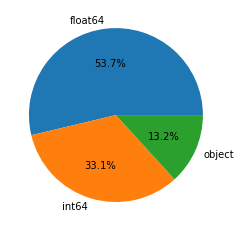

In [97]:
# Types des variables
outils_data.get_types_variables(application_test, True, False, True)

In [98]:
application_test =\
    outils_preprocessing.reduce_mem_usage(application_test, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 45.00 MB
Memory usage après optimization: 14.60 MB
Diminution de 67.6%
-------------------------------------------------------------------------------


In [99]:
# Modification à la main : REGION_RATING_CLIENT contient 1, 2 ou 3
# ==> object
application_test['REGION_RATING_CLIENT'] = \
    application_test['REGION_RATING_CLIENT'].astype('object')
# Modification à la main : REGION_RATING_CLIENT_W_CITY contient
# ==> 1, 2 ou 3 object
application_test['REGION_RATING_CLIENT_W_CITY'] = \
    application_test['REGION_RATING_CLIENT_W_CITY'].astype('object')

In [100]:
# EMERGENCYSTATE_MODE contient Yes/No ==> transformer en 1/0
%pycodestyle_off
dico_emergency = {'Yes' : 0,
                  'No' : 1,
                  np.nan : 0}
outils_data.traduire_valeurs_variable(application_test,
                                      'EMERGENCYSTATE_MODE', dico_emergency)
application_test['EMERGENCYSTATE_MODE'] = \
    application_test['EMERGENCYSTATE_MODE'].astype('int8')
%pycodestyle_on

In [105]:
application_test['EMERGENCYSTATE_MODE'].unique()

array([1, 0], dtype=int8)

In [101]:
# FLAG_OWN_CAR contient Y/N ==> transformer en 1/0
%pycodestyle_off
dico_owncar = {'Y' : 0,
               'N' : 1,
               np.nan : 0}
outils_data.traduire_valeurs_variable(application_test, 'FLAG_OWN_CAR',
                                      dico_owncar)
application_test['FLAG_OWN_CAR'] = \
    application_test['FLAG_OWN_CAR'].astype('int8')
%pycodestyle_on

In [104]:
application_test['FLAG_OWN_CAR'].unique()

array([1, 0], dtype=int8)

In [102]:
# FLAG_OWN_REALTY contient Y/N ==> transformer en 1/0
%pycodestyle_off
dico_ownreal = {'Y' : 0,
                'N' : 1,
                np.nan : 0}
outils_data.traduire_valeurs_variable(application_test, 'FLAG_OWN_REALTY',
                                      dico_ownreal)
application_test['FLAG_OWN_REALTY'] = \
    application_test['FLAG_OWN_REALTY'].astype('int8')
%pycodestyle_on

In [103]:
application_test['FLAG_OWN_REALTY'].unique()

array([0, 1], dtype=int8)

#### <span style='background:Moccasin'>3.2.2. Valeurs aberrantes</span>

Correction des valeurs aberrantes détectées lors de l'EDA.

**DAYS_EMPLOYED**

A partir du percentile 90, la valeur est 365243 jours donc 1000 ans !

In [106]:
# Nombre de ligne erronées
nb_err = \
    application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                      == 365243].count()
pourc_err = round((nb_err*100)/application_test.shape[0], 2)
print(f'Nombre d\'erreurs DAYS_EMPLOYED : {nb_err} ({pourc_err}%)')

Nombre d'erreurs DAYS_EMPLOYED : 9274 (19.03%)


In [107]:
# Correction
application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                  == 365243] = np.nan

In [108]:
# TODO : POURQUOI 30?
# OBS Columns have an erroneous value, we'll remove those values
# application_test['OBS_30_CNT_SOCIAL_CIRCLE']
#  [application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
# application_test['OBS_60_CNT_SOCIAL_CIRCLE']
# [application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan

#### <span style='background:Moccasin'>3.2.3. Valeurs manquantes</span>

In [109]:
# Valeurs manquantes du dataframe
df_nan_applitest = outils_data.get_missing_values(application_test,
                                                   True, False, True)

Valeurs manquantes : 1391484 NaN pour 5898024 données (23.59 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes
COMMONAREA_MEDI,33495,68.7200
COMMONAREA_MODE,33495,68.7200
COMMONAREA_AVG,33495,68.7200
NONLIVINGAPARTMENTS_MODE,33347,68.4100
NONLIVINGAPARTMENTS_AVG,33347,68.4100
NONLIVINGAPARTMENTS_MEDI,33347,68.4100
FONDKAPREMONT_MODE,32797,67.2800
LIVINGAPARTMENTS_MEDI,32780,67.2500
LIVINGAPARTMENTS_AVG,32780,67.2500
LIVINGAPARTMENTS_MODE,32780,67.2500


3:52: E127 50


- Parmi les variables importantes repérées lors de l'analyse exploratoire pour départager les non-défaillants des défaillants, la variable FLOORSMIN_AVG est celle qui a le plus de valeurs manquantes (66.61%).
- On fixera le seuil de suppression des variables ayant de nombreuses valeurs manquantes à 67%.

In [110]:
# Liste des variables ayant plus de 68% de valeurs manquantes
cols_nan_a_suppr_test = \
    df_nan_applitest[df_nan_applitest['% de valeurs manquantes'] > 67] \
    .index.to_list()
print(f'Nombre de variables à supprimer : {len(cols_nan_a_suppr_test)}')
cols_nan_a_suppr_test

Nombre de variables à supprimer : 10


['COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE']

**Bilan** :
***
Les variables à supprimer sont identiques à celles de application_train, ce qui est mieux puisque les jeux d'entraînement et de test doivent contenir les mêmes variables.

In [111]:
# Suppression des variables avec un seuil de nan > 67%
application_test.drop(columns=cols_nan_a_suppr_test, inplace=True)
# Variables catégorielles
cols_cat_test = application_test.select_dtypes(exclude=[np.number]).columns \
    .to_list()
# Variables quantitatives
cols_num_test = application_test.select_dtypes(include=[np.number]).columns \
    .to_list()
# Taille : nombre de lignes/colonnes
nRow, nVar = application_test.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 48744 lignes et 111 variables.


#### <span style='background:Moccasin'>3.2.4. Imputation</span>

**Variables quantitatives**

- Lors de l'analyse exploratoire, nous avons pu observer que les valeurs non renseignées peuvent donner des indications. Le demandeur a pu ne pas donner le renseignement pour éviter d'avoir un refus à sa demande.
- Nous **imputerons** donc les valeurs manquantes des **variables quantitatives** par la valeur **médiane** de chacune de ces variables puisque nous avons découvert lors de l'analyse exploratoire qu'il y avait de nombreux outliers.

In [112]:
# Variables quantitatives - imputation par 0
appli_test_imp1 = application_test.copy()
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
appli_test_imp2 = application_test.copy()

**Imputation par median** 

In [113]:
# Variables quantitatives - imputation par médiane
nb_nan_median_test = application_test[cols_num_test].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median_test}')
application_test.fillna(application_test[cols_num_test].median(), inplace=True)
# Vérification
nb_nan_median_test = application_test[cols_num_test].isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median_test}')

Nombre de nan avant imputation par median : 995793
Nombre de nan après imputation par median : 0


**Imputation par une constante 0** 

In [115]:
# Variables quantitatives - imputation par 0
nb_nan_zero_test = appli_test_imp1[cols_num_test].isna().sum().sum()
print(f'Nombre de nan avant imputation par 0 : {nb_nan_zero_test}')
appli_test_imp1[cols_num_test] = appli_test_imp1[cols_num_test].fillna(0)
# Vérification
nb_nan_zero_test = appli_test_imp1[cols_num_test].isna().sum().sum()
print(f'Nombre de nan après imputation par 0 : {nb_nan_zero_test}')

Nombre de nan avant imputation par 0 : 995793
Nombre de nan après imputation par 0 : 0


**Imputation avec NaNIMputer (Verstack)**

*Note*: [Source](https://medium.com/swlh/impute-missing-values-the-right-way-c63735fccccd)

In [116]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput_test = appli_test_imp2[cols_num_test].isna().sum().sum()

In [118]:
# Copie du jeu de données
df_nan_test = appli_test_imp2.copy()
X_nan_test = df_nan_test[cols_num_test]

In [119]:
# !pip install verstack pour l'installation
imputer = NaNImputer()
X_nan_imputed_test = imputer.impute(X_nan_test)


Dataset dimensions:
 - rows:         48744
 - columns:      97
 - mb in memory: 8.04
 - NaN cols num: 50
--------------------------

Deploy multiprocessing with 12 parallel proceses


NaNs imputation time: 1.51 minutes
--------------------------------------------------


In [123]:
var = 'Nombre de nan après imputation par NaNImputer'
print(f'{var} : {nb_nan_nanimput_test}')
df_tmp_nan_test = pd.DataFrame(X_nan_imputed_test,
                               columns=X_nan_test.columns)
appli_test_imp2[cols_num_test] = df_tmp_nan_test[cols_num_test]
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput_test = appli_test_imp2[cols_num_test].isna().sum().sum()
print(f'{var} : {nb_nan_nanimput_test}')

Nombre de nan après imputation par NaNImputer : 995793
Nombre de nan après imputation par NaNImputer : 0


In [124]:
fic_sav_appl2_test = '../sauvegarde/pre-processing/appli_test_imp2.pickle'

In [125]:
# Sauvegarde de appli_train_imp2
with open(fic_sav_appl2_test, 'wb') as f:
    pickle.dump(appli_test_imp2, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Chargement de appli_train_imp2
with open(fic_sav_appl2_test, 'rb') as df_appli_test_2:
    appli_test_imp2 = pickle.load(df_appli_train_2)
appli_train_imp2.shape

**Variable qualitatives**

- Lors de l'analyse exploratoire, nous avons pu observer que les valeurs non renseignées peuvent donner des indications. Le demandeur a pu ne pas donner le renseignement pour éviter d'avoir un refus à sa demande.
- Nous imputerons donc les valeurs manquantes des variables qualitatives par la valeur mode de chacune de ces variables.

In [126]:
# TODO :
# Imputation :  toutes les variables par XNA? par mode?
# Est-ce que je fais plusieurs tests?

**Imputation par le mode de la catégorie**

In [127]:
# Variables qualitatives - imputation par mode de la variable
nb_nan_cat_test = application_test[cols_cat_test].isna().sum().sum()
print(f'Nombre de nan avant imputation par mode : {nb_nan_cat_test}')
for var in cols_cat_test:
    mode = application_test[var].mode()[0]
    application_test[var].fillna(mode, inplace=True)
nb_nan_cat_test = application_test[cols_cat_test].isna().sum().sum()
print(f'Nombre de nan après imputation par mode : {nb_nan_cat_test}')

Nombre de nan avant imputation par mode : 64028
Nombre de nan après imputation par mode : 0


**Imputation par une constante XNA**

In [129]:
cols_cat_test

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [133]:
# Variables quantitatives - imputation par XNA
%pycodestyle_off
nb_nan_xna_test = appli_test_imp1[cols_cat_test].isna().sum().sum()
print(f'Nombre de nan avant imputation par XNA : {nb_nan_xna_test}')
for var in cols_cat_test :
    appli_test_imp1[var] = appli_test_imp1[var].fillna('XNA')
# Vérification
nb_nan_xna_test = appli_test_imp1[cols_cat_test].isna().sum().sum()
print(f'Nombre de nan après imputation par XNA : {nb_nan_xna_test}')
%pycodestyle_on

Nombre de nan avant imputation par XNA : 64028
Nombre de nan après imputation par XNA : 0


In [137]:
# Variables quantitatives - imputation par XNA
%pycodestyle_off
nb_nan_xna2_test = appli_test_imp2[cols_cat_test].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_xna2_test}')
for var in cols_cat_test :
    appli_test_imp2[var] = appli_test_imp2[var].fillna('XNA')
# Vérification
nb_nan_xna2_test = appli_test_imp2[cols_cat_test].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_xna2_test}')
%pycodestyle_on

Nombre de nan avant imputation par median : 64028
Nombre de nan avant imputation par median : 0


**Bilan**:
- application_test : 
    - variables quantitatives imputées par median.
    - variables qualitatives imputées par mode.
- appli_test_imp1 :
    - variables quantitatives imputées par la constante 0.
    - variables qualitatives imputées par la constante XNA.
- appli_test_imp2 :
    - variables quantitatives imputées par NaNImputer.
    - variables qualitatives imputées par la constante XNA.

In [138]:
# Vérification : plus de nan
# Valeurs manquantes du dataframe application_test
print(f'Nombre nan application_test : {application_test.isna().sum().sum()}')
# Sauvegarde de application_test
fic_sav_appltest_sansnan = \
    '../sauvegarde/pre-processing/application_test_sans_nan.pickle'
with open(fic_sav_appltest_sansnan, 'wb') as f:
    pickle.dump(application_test, f, pickle.HIGHEST_PROTOCOL)
# Valeurs manquantes du dataframe appli_test_imp1
print(f'Nombre nan appli_test_imp1 : {appli_test_imp1.isna().sum().sum()}')
# Sauvegarde de appli_test_imp1
fic_sav_appltestimp1_sansnan = \
    '../sauvegarde/pre-processing/appli_test_imp1_sans_nan.pickle'
with open(fic_sav_appltestimp1_sansnan, 'wb') as f:
    pickle.dump(appli_test_imp1, f, pickle.HIGHEST_PROTOCOL)
# Valeurs manquantes du dataframe appli_test_imp2
print(f'Nombre nan appli_test_imp2 : {appli_test_imp2.isna().sum().sum()}')
# Sauvegarde de appli_test_imp2
fic_sav_appltestimp2_sansnan = \
    '../sauvegarde/pre-processing/appli_test_imp2_sans_nan.pickle'
with open(fic_sav_appltestimp2_sansnan, 'wb') as f:
    pickle.dump(appli_test_imp2, f, pickle.HIGHEST_PROTOCOL)

Nombre nan application_test : 0
Nombre nan appli_test_imp1 : 0
Nombre nan appli_test_imp2 : 0


#### <span style='background:Moccasin'>3.2.5. Feature engineering</span>

**Variables métiers & automatiques (mean, max...)**

In [139]:
# Feature engineering pour le dataframe application_test
application_test = \
    outils_preprocessing.feature_engineering_application(application_test)
application_test.shape

(48744, 169)

In [140]:
# Feature engineering pour le dataframe appli_test_imp1
appli_test_imp1 = \
    outils_preprocessing.feature_engineering_application(appli_test_imp1)
appli_test_imp1.shape

(48744, 169)

In [141]:
# Feature engineering pour le dataframe appli_test_imp2
appli_test_imp2 = \
    outils_preprocessing.feature_engineering_application(appli_test_imp2)
appli_test_imp2.shape

(48744, 169)

**Super variable du gagnant du concours Kaggle**

In [142]:
# TODO : voir si on utilise car d'après soutenance pas explicable?

- Imputation de la moyenne des 500 valeurs cibles des voisins les plus proches pour chaque application du train set ou test set.
- Les voisins sont calculés en utilisant :
    - les variables très importantes :
        - EXT_SOURCE-1, 
        - EXT_SOURCE_2 
        - et EXT_SOURCE_3,
    - et CREDIT_ANNUITY_RATIO (ratio du Montant du crédit du prêt / Annuité de prêt).
[Source](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821)    

In [145]:
# Feature engineering super variable pour le dataframe application_test
outils_preprocessing. \
    feature_engineering_neighbors_EXT_SOURCE_test(application_train,
                                                  application_test)
application_test.shape

(48744, 170)

In [146]:
# Feature engineering super variable pour le dataframe appli_test_imp1
outils_preprocessing. \
    feature_engineering_neighbors_EXT_SOURCE_test(appli_train_imp1,
                                                  appli_test_imp1)
appli_test_imp1.shape

(48744, 170)

In [148]:
# Feature engineering super variable pour le dataframe appli_test_imp2
outils_preprocessing. \
    feature_engineering_neighbors_EXT_SOURCE_test(appli_train_imp2,
                                                  appli_test_imp2)
appli_test_imp2.shape

(48744, 170)

#### <span style='background:Moccasin'>3.2.6. Encodage des variables qualitatives</span>

In [149]:
# Liste des variables catégorielles
cols_cat_test

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE']

In [150]:
# Résumé des variables qualitatives
desc_cat_test = outils_data.description_variables(application_test, 'cat')
desc_cat_test

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,HOUSETYPE_MODE,WALLSMATERIAL_MODE
type,object,object,object,object,object,object,object,object,object,object,object,object
nb_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,48744,48744,48744,48744,48744,48744,48744,48744,48744,48744,48744,48744
unique,2,2,7,7,5,5,6,18,7,58,3,7
top,Cash loans,F,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,block of flats,Panel
freq,48305,32678,40638,24533,33988,32283,43645,24260,9751,10840,48278,35162


In [151]:
# Variables avec 2 catégories uniques
%pycodestyle_off
df_tmp_test = pd.DataFrame(desc_cat_test.loc['unique', :] <= 2)
liste_2cat_test = df_tmp_test[df_tmp_test['unique'] == True].index.to_list()
%pycodestyle_on
liste_2cat_test

['NAME_CONTRACT_TYPE', 'CODE_GENDER']

In [152]:
# Variables avec plus de 15 catégories uniques
%pycodestyle_off
df_tmp2_test = pd.DataFrame(desc_cat_test.loc['unique', :] > 15)
liste_catsup15_test = df_tmp2_test[df_tmp2_test['unique'] == True].index.to_list()
%pycodestyle_on
liste_catsup15_test

['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

**Bilan** :
***
Même constat que pour le dataframe application_train :
- 2 variables ne contiennent que 2 catégories, on encodera ces varaibles avec LabelEncoder :
    - 'NAME_CONTRACT_TYPE',
    - et 'CODE_GENDER'.
- 2 variables avec plus de 15 catégories, on tentera d'encoder avec OneHotEncoder dans un premier temps et si on a des problèmes mémoires avec TargetEncoder :
    - 'OCCUPATION_TYPE', 
    - et 'ORGANIZATION_TYPE'.

**LabelEncoder**

Les 2 variables qualitatives avec seulement 2 types de catégories seront imputées avec LabelEncoder.

In [153]:
%pycodestyle_off
le = LabelEncoder()
for var in liste_2cat_test:
    # Dataframe application_test
    le.fit(application_test[var])
    application_test[var] = le.transform(application_test[var])
    # Dataframe appli_test_imp1
    le.fit(appli_test_imp1[var])
    appli_test_imp1[var] = le.transform(appli_test_imp1[var])
    # Dataframe appli_test_imp2
    le.fit(appli_test_imp2[var])
    appli_test_imp2[var] = le.transform(appli_test_imp2[var])
%pycodestyle_on

**Bilan** :
- Variable CODE_GENDER :
    - 0 : Feminin
    - 1 : Masculin
- Variable CODE_GENDER :
    - 0 : Cash loans
    - 1 : Revolving loans 

**OneHotEncoder**

Les variables qualitatives avec plus de 2 catégories seront encodées avec OneHotEncoder.

In [157]:
# Onehot encoding pour le reste des variables
# Dataframe application_test
application_test = pd.get_dummies(application_test)
print(f'application_test : {application_test.shape}')
# Dataframe appli_test_imp1
appli_test_imp1 = pd.get_dummies(appli_test_imp1)
print(f'appli_test_imp1 : {appli_test_imp1.shape}')
# Dataframe appli_test_imp2
appli_test_imp2 = pd.get_dummies(appli_test_imp2)
print(f'appli_test_imp2 : {appli_test_imp2.shape}')

application_test : (48744, 283)
appli_test_imp1 : (48744, 287)
appli_test_imp2 : (48744, 287)


In [ ]:
# Variables en plus?
list1 = set(application_train.columns.to_list())
list2 = set(appli_train_imp1 .columns.to_list())
list2 ^ list1

#### <span style='background:Moccasin'>3.2.7. Gestion des fortes corrélations</span>

Suppression des variables fortement corrélées pour le dataframe application_train.

**application_test**

In [158]:
# Réduction de la mémoire pour les nouvelles variables
application_test =\
    outils_preprocessing.reduce_mem_usage(application_test, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 29.29 MB
Memory usage après optimization: 25.85 MB
Diminution de 11.7%
-------------------------------------------------------------------------------


In [159]:
# Types des variables
outils_data.get_types_variables(application_test, True, True, False)

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                                             int32
NAME_CONTRACT_TYPE                                      int8
CODE_GENDER                                             int8
FLAG_OWN_CAR                                            int8
FLAG_OWN_REALTY                                         int8
CNT_CHILDREN                                            int8
AMT_INCOME_TOTAL                                     float32
AMT_CREDIT                                           float32
AMT_ANNUITY                                          float32
AMT_GOODS_PRICE                                      float32
REGION_POPULATION_RELATIVE                           float16
DAYS_BIRTH                                             int16
DAYS_EMPLOYED                                        float16
DAYS_REGISTRATION                                    float16
DAYS_ID_PUBLISH                                        int16
OWN_CAR_AGE                                          float16
FLAG_MOBIL              

,Nombre par type de variable,% des types de variable
float16,217,76.6800
int8,46,16.2500
float32,17,6.0100
int16,2,0.7100
int32,1,0.3500


In [160]:
# Suppression des variables fortement corrélées
print(f'application_test : {application_test.shape}')
application_test.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_test : {application_test.shape}')

application_test : (48744, 283)
application_test : (48744, 205)


In [163]:
application_train.shape

(307507, 206)

In [164]:
# Sauvegarde de application_test nettoyée, encodée, prête pour ML
fic_sav_application_test = \
    '../sauvegarde/pre-processing/application_test_clean.pickle'
with open(fic_sav_application_test, 'wb') as f:
    pickle.dump(application_test, f, pickle.HIGHEST_PROTOCOL)

**appli_test_imp1**

In [165]:
# Réduction de la mémoire pour les nouvelles variables
appli_test_imp1 =\
    outils_preprocessing.reduce_mem_usage(appli_test_imp1, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 29.47 MB
Memory usage après optimization: 26.50 MB
Diminution de 10.1%
-------------------------------------------------------------------------------


In [166]:
# Types des variables
outils_data.get_types_variables(appli_test_imp1, True, True, False)

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                                             int32
NAME_CONTRACT_TYPE                                      int8
CODE_GENDER                                             int8
FLAG_OWN_CAR                                            int8
FLAG_OWN_REALTY                                         int8
CNT_CHILDREN                                            int8
AMT_INCOME_TOTAL                                     float32
AMT_CREDIT                                           float32
AMT_ANNUITY                                          float32
AMT_GOODS_PRICE                                      float32
REGION_POPULATION_RELATIVE                           float16
DAYS_BIRTH                                             int16
DAYS_EMPLOYED                                        float16
DAYS_REGISTRATION                                    float16
DAYS_ID_PUBLISH                                        int16
OWN_CAR_AGE                                          float16
FLAG_MOBIL              

,Nombre par type de variable,% des types de variable
float16,218,75.9600
int8,46,16.0300
float32,20,6.9700
int16,2,0.7000
int32,1,0.3500


In [167]:
# Suppression des variables fortement corrélées
print(f'appli_test_imp1 : {appli_test_imp1.shape}')
appli_test_imp1.drop(columns=cols_corr1_a_supp,  inplace=True)
print(f'appli_test_imp1 : {appli_test_imp1.shape}')

appli_test_imp1 : (48744, 287)
appli_test_imp1 : (48744, 210)


In [173]:
appli_train_imp1.shape

(307507, 213)

In [184]:
# Manque 2 variables : Valeurs np.nan remplacées par XNA en plus dans
# appli_train_imp1 mais pas de np.nan dans appli_test_imp1 :
# 'NAME_INCOME_TYPE_XNA'
# et 'NAME_FAMILY_STATUS_XNA'
# Ajout d'une variable 'NAME_INCOME_TYPE_XNA' avec 0.0 float16
appli_test_imp1['NAME_INCOME_TYPE_XNA'] = 0.0
appli_test_imp1['NAME_INCOME_TYPE_XNA'].astype('float16')
# Ajout d'une variable 'NAME_FAMILY_STATUS_XNA' avec 0.0 float16
appli_test_imp1['NAME_FAMILY_STATUS_XNA'] = 0.0
appli_test_imp1['NAME_FAMILY_STATUS_XNA'].astype('float16')
appli_test_imp1.shape

(48744, 212)

In [185]:
# Sauvegarde de appli_test_imp1 nettoyée, encodée, prête pour ML
fic_sav_appli_test_imp1 = \
    '../sauvegarde/pre-processing/appli_test_imp1_clean.pickle'
with open(fic_sav_appli_test_imp1, 'wb') as f:
    pickle.dump(appli_test_imp1, f, pickle.HIGHEST_PROTOCOL)

**appli_test_imp2**

In [186]:
# Réduction de la mémoire pour les nouvelles variables
appli_test_imp2 =\
    outils_preprocessing.reduce_mem_usage(appli_test_imp2, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 29.47 MB
Memory usage après optimization: 26.22 MB
Diminution de 11.0%
-------------------------------------------------------------------------------


In [187]:
# Types des variables
outils_data.get_types_variables(appli_test_imp2, True, True, False)

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                                             int32
NAME_CONTRACT_TYPE                                      int8
CODE_GENDER                                             int8
FLAG_OWN_CAR                                            int8
FLAG_OWN_REALTY                                         int8
CNT_CHILDREN                                            int8
AMT_INCOME_TOTAL                                     float32
AMT_CREDIT                                           float32
AMT_ANNUITY                                          float32
AMT_GOODS_PRICE                                      float32
REGION_POPULATION_RELATIVE                           float16
DAYS_BIRTH                                             int16
DAYS_EMPLOYED                                        float16
DAYS_REGISTRATION                                    float16
DAYS_ID_PUBLISH                                        int16
OWN_CAR_AGE                                          float16
FLAG_MOBIL              

,Nombre par type de variable,% des types de variable
float16,221,77.0000
int8,46,16.0300
float32,17,5.9200
int16,2,0.7000
int32,1,0.3500


In [188]:
# Suppression des variables fortement corrélées
print(f'appli_test_imp2 : {appli_test_imp2.shape}')
appli_test_imp2.drop(columns=cols_corr2_a_supp,  inplace=True)
print(f'appli_test_imp2 : {appli_test_imp2.shape}')

appli_test_imp2 : (48744, 287)
appli_test_imp2 : (48744, 204)


In [189]:
appli_train_imp2.shape

(307507, 207)

In [192]:
# Manque 2 variables : Valeurs np.nan remplacées par XNA en plus dans
# appli_train_imp2 mais pas de np.nan dans appli_test_imp1 :
# 'NAME_INCOME_TYPE_XNA'
# et 'NAME_FAMILY_STATUS_XNA'
# Ajout d'une variable 'NAME_INCOME_TYPE_XNA' avec 0.0 float16
appli_test_imp2['NAME_INCOME_TYPE_XNA'] = 0.0
appli_test_imp2['NAME_INCOME_TYPE_XNA'].astype('float16')
# Ajout d'une variable 'NAME_FAMILY_STATUS_XNA' avec 0.0 float16
appli_test_imp2['NAME_FAMILY_STATUS_XNA'] = 0.0
appli_test_imp2['NAME_FAMILY_STATUS_XNA'].astype('float16')
appli_test_imp2.shape

(48744, 206)

In [193]:
# Sauvegarde de appli_test_imp2 nettoyée, encodée, prête pour ML
fic_sav_appli_test_imp2 = \
    '../sauvegarde/pre-processing/appli_test_imp2_clean.pickle'
with open(fic_sav_appli_test_imp2, 'wb') as f:
    pickle.dump(appli_test_imp2, f, pickle.HIGHEST_PROTOCOL)

**Chargement des dataframes nettoyés**

In [36]:
fic_sav_application_test = \
    '../sauvegarde/pre-processing/application_test_clean.pickle'
# Chargement de application_test
with open(fic_sav_application_test, 'rb') as df_appli_test_clean:
    application_test = pickle.load(df_appli_test_clean)
application_test.shape

(48744, 205)

In [37]:
fic_sav_appli_test_imp1 = \
    '../sauvegarde/pre-processing/appli_test_imp1_clean.pickle'
# Chargement de appli_test_imp1
with open(fic_sav_appli_test_imp1, 'rb') as df_appli_test_1_clean:
    appli_test_imp1 = pickle.load(df_appli_test_1_clean)
appli_test_imp1.shape

(48744, 212)

In [38]:
fic_sav_appli_test_imp2 = \
    '../sauvegarde/pre-processing/appli_test_imp2_clean.pickle'
# Chargement de appli_test_imp2
with open(fic_sav_appli_test_imp2, 'rb') as df_appli_test_2_clean:
    appli_test_imp2 = pickle.load(df_appli_test_2_clean)
appli_test_imp2.shape

(48744, 206)

## <span style='background:Thistle'>4. Données des prêts antérieurs chez Home Crédit Group</span>

4 fichiers contiennent des informations sur les prêts antérieurs chez Home Crédit :
- Le fichier principal des prêts antérieurs :
    - **previous_application**.
- Le détail sur ces prêts antérieurs :
    - **credit_card_balance**,
    - **installments_payments**,
    - **POS_CASH_balance**.

  ### <span style='background:PowderBlue'>4.1. Fichiers credit_card_balance.csv</span>

**Présentation**

| Fichier | Description |
| --- | --- |
| <p style='text-align: justify;'>**credit_card_balance.csv** | <ul style='text-align: justify;'><li>Instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède chez Home Credit. </li> <li>  Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans le Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.</li></ul>|

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_PREV**</p> | <ul style='text-align: justify;'><li>ID du crédit précédent dans le crédit immobilier lié au prêt dans notre échantillon.</li> <li>Un prêt dans notre échantillon peut avoir 0 ou 1 ou 2 ou plus de prêts précédents dans Home Credit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <p style='text-align: justify;'>ID du prêt dans notre échantillon</p> |  |
| <p style='text-align: justify;'>**MONTHS_BALANCE**</p> | <p style='text-align: justify;'>Mois du solde par rapport à la date d'application.</p> | -1 signifie la date de solde la plus récente |
| <p style='text-align: justify;'>**AMT_BALANCE**</p> | <p style='text-align: justify;'>Solde au cours du mois du crédit précédent</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_LIMIT_ACTUAL**</p> | <p style='text-align: justify;'>Limite de la carte de crédit au cours du mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_DRAWINGS_CURRENT**</p> | <p style='text-align: justify;'>Montant prélevé au cours du mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_DRAWINGS_OTHER_CURRENT**</p> | <p style='text-align: justify;'>Montant des autres prélèvements au cours du mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_DRAWINGS_POS_CURRENT**</p> | <p style='text-align: justify;'>Montant des prélèvements ou des achats de marchandises au cours du mois de la crédibilité précédente.</p> |  |
| <p style='text-align: justify;'>**AMT_INST_MIN_REGULARITY**</p> | <p style='text-align: justify;'>Versement minimal pour ce mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_PAYMENT_CURRENT**</p> | <p style='text-align: justify;'>Combien le client a-t-il payé pendant le mois sur le crédit précédent ?</p> |  |
| <p style='text-align: justify;'>**AMT_PAYMENT_TOTAL_CURRENT**</p> | <p style='text-align: justify;'>Combien le client a-t-il payé au total pendant le mois sur le crédit précédent ?</p> |  |
| <p style='text-align: justify;'>**AMT_RECEIVABLE_PRINCIPAL**</p> | <p style='text-align: justify;'>Montant à recevoir pour le principal du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_RECIVABLE**</p> | <p style='text-align: justify;'>Montant à recevoir sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_TOTAL_RECEIVABLE**</p> | <p style='text-align: justify;'>Montant total à recevoir sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_DRAWINGS_ATM_CURRENT**</p> | <p style='text-align: justify;'>Nombre de tirages au guichet automatique durant ce mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_DRAWINGS_CURRENT**</p> | <p style='text-align: justify;'>Nombre de tirages pendant ce mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_DRAWINGS_OTHER_CURRENT**</p> | <p style='text-align: justify;'>Nombre d'autres tirages au cours de ce mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_DRAWINGS_POS_CURRENT**</p> | <p style='text-align: justify;'>ombre de tirages de marchandises durant ce mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_INSTALMENT_MATURE_CUM**</p> | <p style='text-align: justify;'>Nombre d'échéances payées sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**NAME_CONTRACT_STATUS**</p> | <p style='text-align: justify;'>Statut du contrat (actif signé...) sur le crédit précédent.</p> | <ul style='text-align: justify;'><li>Active</li> <li>Completed</li> <li>Signed</li> <li>Sent proposal</li> <li>Refused</li> <li>Demand</li> <li>Approved</li></ul> |
| <p style='text-align: justify;'>**SK_DPD**</p> | <p style='text-align: justify;'>DPD (jours de retard) au cours du mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**SK_DPD_DEF**</p> | <p style='text-align: justify;'>DPD (Jours de retard) au cours du mois avec tolérance (les dettes avec de faibles montants de prêt sont ignorées) du crédit précédent.</p> |  |

In [60]:
# Taille : nombre de lignes/colonnes
nRow, nVar = cc_balance.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 3840312 lignes et 23 variables.


In [61]:
# Variables quantitatives
cols_num_ccb = cc_balance.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_ccb

['SK_ID_PREV',
 'SK_ID_CURR',
 'MONTHS_BALANCE',
 'AMT_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'SK_DPD',
 'SK_DPD_DEF']

In [62]:
# Variables catégorielles
cols_cat_ccb = cc_balance.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_ccb

['NAME_CONTRACT_STATUS']

In [63]:
# Résumé des variables
desc_ccb = outils_data.description_variables(cc_balance)
desc_ccb

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
type,int64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,int64,int64
nb_nan,0.0,0.0,0.0,0.0,0.0,749816.0,0.0,749816.0,749816.0,305236.0,767988.0,0.0,0.0,0.0,0.0,749816.0,0.0,749816.0,749816.0,305236.0,0.0,0.0,0.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.8489,0.0,0.8489,0.8489,0.3456,0.8695,0.0,0.0,0.0,0.0,0.8489,0.0,0.8489,0.8489,0.3456,0.0,0.0,0.0
count,3840312.0,3840312.0,3840312.0,3840312.0,3840312.0,3090496.0,3840312.0,3090496.0,3090496.0,3535076.0,3072324.0,3840312.0,3840312.0,3840312.0,3840312.0,3090496.0,3840312.0,3090496.0,3090496.0,3535076.0,3840312,3840312.0,3840312.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Active,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3698436,NaN,NaN
mean,1904503.5899,278324.2073,-34.5219,58300.1553,153807.9574,5961.3248,7433.3882,288.1696,2968.8048,3540.2041,10280.5377,7588.8567,55965.8769,58088.8112,58098.2855,0.3094,0.7031,0.0048,0.5595,20.8251,NaN,9.2837,0.3316
std,536469.4706,102704.4751,26.6678,106307.031,165145.6995,28225.6886,33846.0773,8201.9893,20796.887,5600.1541,36078.085,32005.9878,102533.6168,105965.3699,105971.8011,1.1004,3.1903,0.0826,3.2406,20.0515,NaN,97.5157,21.4792
min,1000018.0,100006.0,-96.0,-420250.185,0.0,-6827.31,-6211.62,0.0,0.0,0.0,0.0,0.0,-423305.82,-420250.185,-420250.185,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


Lors de l'analyse exploratoire, nous avons constaté un outlier isolé pour la variable AMT_PAYMENT_CURRENT avec une valeur de 4289207.445, à corriger au niveau du feature engineering.

#### <span style='background:Moccasin'>4.1.1. Types des objets</span>

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

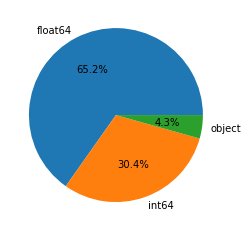

In [64]:
# Types des variables
outils_data.get_types_variables(cc_balance, True, False, True)

In [65]:
cc_balance = outils_preprocessing.reduce_mem_usage(cc_balance,
                                                   verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 673.88 MB
Memory usage après optimization: 289.33 MB
Diminution de 57.1%
-------------------------------------------------------------------------------


#### <span style='background:Moccasin'>4.1.2. Valeurs aberrantes</span>

Lors de l'analyse exploratoire, nous avons constaté un outlier isolé pour la variable **AMT_PAYMENT_CURRENT** avec une valeur de 4289207.445, nous ré.

**AMT_PAYMENT_CURRENT**

In [69]:
# Suppression des valeurs remontant à plus de 80 ans
cc_balance['AMT_PAYMENT_CURRENT'][cc_balance['AMT_PAYMENT_CURRENT']
                                  > 4000000] = np.nan

#### <span style='background:Moccasin'>4.1.3. Feature engineering</span>

[Source](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

 <span style='background:Plum'>**Variables métiers**</span>

In [76]:
# Somme : Montant retiré au guichet automatique pendant le mois du crédit
#         précédent + Montant prélevé au cours du mois du crédit précédent
#         + Montant des autres prélèvements au cours du mois du crédit
#         précédent + Montant des prélèvements ou des achats de
# marchandises au cours du mois de la crédibilité précédente.
cc_balance['AMT_DRAWING_SUM'] = cc_balance['AMT_DRAWINGS_ATM_CURRENT'] \
    + cc_balance['AMT_DRAWINGS_CURRENT'] \
    + cc_balance['AMT_DRAWINGS_OTHER_CURRENT'] \
    + cc_balance['AMT_DRAWINGS_POS_CURRENT']

# Somme : Nombre de retraits au guichet automatique durant ce mois sur
#         le crédit précédent + Nombre de retraits pendant ce mois sur
#         le crédit précédent + Nombre d'autres retraits au cours de
#         ce mois sur le crédit précédent + Nombre de retraits de
#         marchandises durant ce mois sur le crédit précédent +
#         Nombre d'échéances payées sur le crédit précédent
cc_balance['CNT_DRAWING_SUM'] = cc_balance['CNT_DRAWINGS_ATM_CURRENT'] \
    + cc_balance['CNT_DRAWINGS_CURRENT'] \
    + cc_balance['CNT_DRAWINGS_OTHER_CURRENT'] \
    + cc_balance['CNT_DRAWINGS_POS_CURRENT'] \
    + cc_balance['CNT_INSTALMENT_MATURE_CUM']

# Ratio : Solde au cours du mois du crédit précédent \
#         Limite de la carte de crédit au cours du mois du crédit précédent
cc_balance['BALANCE_LIMIT_RATIO'] = cc_balance['AMT_BALANCE'] / \
    (cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)

# Ratio : Combien le client a-t-il payé pendant le mois sur le crédit
#         précédent ? /
#         Versement minimal pour ce mois du crédit précédent
cc_balance['MIN_PAYMENT_RATIO'] = cc_balance['AMT_PAYMENT_CURRENT'] / \
    (cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
# Différence : Combien le client a-t-il payé pendant le mois sur le crédit
#              précédent ?
#              - Versement minimal pour ce mois du crédit précédent
cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_CURRENT'] - \
    cc_balance['AMT_INST_MIN_REGULARITY']

# Ratio : Combien le client a-t-il payé au total pendant le mois sur le
#         crédit précédent ? /
#         Versement minimal pour ce mois du crédit précédent
cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = \
    cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] \
    / (cc_balance['AMT_INST_MIN_REGULARITY'] + 0.00001)
# Différence : Combien le client a-t-il payé au total pendant le mois sur
#              le crédit précédent ? -
#              Versement minimal pour ce mois du crédit précédent
cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] \
    - cc_balance['AMT_INST_MIN_REGULARITY']

# Différence : Montant total à recevoir sur le crédit précédent -
#              Montant à recevoir pour le principal du crédit précédent
cc_balance['AMT_INTEREST_RECEIVABLE'] = cc_balance['AMT_TOTAL_RECEIVABLE'] \
    - cc_balance['AMT_RECEIVABLE_PRINCIPAL']

# Ratio : DPD (jours de retard) au cours du mois sur le crédit précédent \
#         DPD (Days past due) au cours du mois avec tolérance (les dettes
#         avec de faibles montants de prêt sont ignorées) du crédit
#         précédent
cc_balance['SK_DPD_RATIO'] = cc_balance['SK_DPD'] / \
    (cc_balance['SK_DPD_DEF'] + 0.00001)

 <span style='background:Plum'>**Variables statistiques automatiques**</span>

Création des variables statistiques mean, max, min, last, first...

***
**Variables quantitatives**
***

In [77]:
# Ajout des variables de statistiques
dico_agg_ccb = {'MONTHS_BALANCE': ['max'],
                'AMT_BALANCE' : ['sum', 'mean', 'max'],
                'AMT_CREDIT_LIMIT_ACTUAL' : ['sum', 'mean', 'max'],
                'AMT_DRAWINGS_ATM_CURRENT' : ['sum', 'max'],
                'AMT_DRAWINGS_CURRENT' : ['sum', 'max'],
                'AMT_DRAWINGS_OTHER_CURRENT' : ['sum', 'max'],
                'AMT_DRAWINGS_POS_CURRENT' : ['sum', 'max'],
                'AMT_INST_MIN_REGULARITY' : ['mean', 'min', 'max'],
                'AMT_PAYMENT_CURRENT' : ['mean', 'min', 'max'],
                'AMT_PAYMENT_TOTAL_CURRENT' : ['mean', 'min', 'max'],
                'AMT_RECEIVABLE_PRINCIPAL' : ['sum', 'mean', 'max'],
                'AMT_RECIVABLE' : ['sum', 'mean', 'max'],
                'AMT_TOTAL_RECEIVABLE' : ['sum', 'mean', 'max'],
                'CNT_DRAWINGS_ATM_CURRENT' : ['sum', 'max', 'mean'],
                'CNT_DRAWINGS_CURRENT' : ['sum', 'max', 'mean'],
                'CNT_DRAWINGS_OTHER_CURRENT' : ['sum', 'max'],
                'CNT_DRAWINGS_POS_CURRENT' : ['sum', 'max'],
                'CNT_INSTALMENT_MATURE_CUM' : ['sum', 'max', 'min'],
                'SK_DPD' : ['sum', 'max'],
                'SK_DPD_DEF' : ['sum', 'max'],
                # Nouvelles Features
                'AMT_DRAWING_SUM' : ['sum', 'max'],
                'BALANCE_LIMIT_RATIO' : ['mean', 'max', 'min'],
                'CNT_DRAWING_SUM' : ['sum', 'max'],
                'MIN_PAYMENT_RATIO': ['min', 'mean'],
                'PAYMENT_MIN_DIFF' : ['min', 'mean'],
                'MIN_PAYMENT_TOTAL_RATIO' : ['min', 'mean'], 
                'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
                'SK_DPD_RATIO' : ['max','mean']}
%pycodestyle_off
agg_ccb_num = \
    outils_preprocessing.agg_var_num(cc_balance.drop(columns=['SK_ID_PREV']),
                                     'SK_ID_CURR', dico_agg_ccb, 'CCB')
%pycodestyle_on
print(f'{agg_ccb_num.shape}')
agg_ccb_num.head()

(103558, 68)


,SK_ID_CURR,CCB_MONTHS_BALANCE_MAX,CCB_AMT_BALANCE_SUM,CCB_AMT_BALANCE_MEAN,CCB_AMT_BALANCE_MAX,CCB_AMT_CREDIT_LIMIT_ACTUAL_SUM,CCB_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CCB_AMT_CREDIT_LIMIT_ACTUAL_MAX,CCB_AMT_DRAWINGS_ATM_CURRENT_SUM,CCB_AMT_DRAWINGS_ATM_CURRENT_MAX,CCB_AMT_DRAWINGS_CURRENT_SUM,CCB_AMT_DRAWINGS_CURRENT_MAX,CCB_AMT_DRAWINGS_OTHER_CURRENT_SUM,CCB_AMT_DRAWINGS_OTHER_CURRENT_MAX,CCB_AMT_DRAWINGS_POS_CURRENT_SUM,CCB_AMT_DRAWINGS_POS_CURRENT_MAX,CCB_AMT_INST_MIN_REGULARITY_MEAN,CCB_AMT_INST_MIN_REGULARITY_MIN,CCB_AMT_INST_MIN_REGULARITY_MAX,CCB_AMT_PAYMENT_CURRENT_MEAN,CCB_AMT_PAYMENT_CURRENT_MIN,CCB_AMT_PAYMENT_CURRENT_MAX,CCB_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CCB_AMT_PAYMENT_TOTAL_CURRENT_MIN,CCB_AMT_PAYMENT_TOTAL_CURRENT_MAX,CCB_AMT_RECEIVABLE_PRINCIPAL_SUM,CCB_AMT_RECEIVABLE_PRINCIPAL_MEAN,CCB_AMT_RECEIVABLE_PRINCIPAL_MAX,CCB_AMT_RECIVABLE_SUM,CCB_AMT_RECIVABLE_MEAN,CCB_AMT_RECIVABLE_MAX,CCB_AMT_TOTAL_RECEIVABLE_SUM,CCB_AMT_TOTAL_RECEIVABLE_MEAN,CCB_AMT_TOTAL_RECEIVABLE_MAX,CCB_CNT_DRAWINGS_ATM_CURRENT_SUM,CCB_CNT_DRAWINGS_ATM_CURRENT_MAX,CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN,CCB_CNT_DRAWINGS_CURRENT_SUM,CCB_CNT_DRAWINGS_CURRENT_MAX,CCB_CNT_DRAWINGS_CURRENT_MEAN,CCB_CNT_DRAWINGS_OTHER_CURRENT_SUM,CCB_CNT_DRAWINGS_OTHER_CURRENT_MAX,CCB_CNT_DRAWINGS_POS_CURRENT_SUM,CCB_CNT_DRAWINGS_POS_CURRENT_MAX,CCB_CNT_INSTALMENT_MATURE_CUM_SUM,CCB_CNT_INSTALMENT_MATURE_CUM_MAX,CCB_CNT_INSTALMENT_MATURE_CUM_MIN,CCB_SK_DPD_SUM,CCB_SK_DPD_MAX,CCB_SK_DPD_DEF_SUM,CCB_SK_DPD_DEF_MAX,CCB_AMT_DRAWING_SUM_SUM,CCB_AMT_DRAWING_SUM_MAX,CCB_BALANCE_LIMIT_RATIO_MEAN,CCB_BALANCE_LIMIT_RATIO_MAX,CCB_BALANCE_LIMIT_RATIO_MIN,CCB_CNT_DRAWING_SUM_SUM,CCB_CNT_DRAWING_SUM_MAX,CCB_MIN_PAYMENT_RATIO_MIN,CCB_MIN_PAYMENT_RATIO_MEAN,CCB_PAYMENT_MIN_DIFF_MIN,CCB_PAYMENT_MIN_DIFF_MEAN,CCB_MIN_PAYMENT_TOTAL_RATIO_MIN,CCB_MIN_PAYMENT_TOTAL_RATIO_MEAN,CCB_AMT_INTEREST_RECEIVABLE_MIN,CCB_AMT_INTEREST_RECEIVABLE_MEAN,CCB_SK_DPD_RATIO_MAX,CCB_SK_DPD_RATIO_MEAN
0,100006,-1,0.0000e+00,0.0000,0.0000,1620000,270000.0000,270000,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0000,0.0,0.0,NaN,NaN,NaN,0.0000,0.0,0.0,0.0000e+00,0.0000,0.0,0.0000e+00,0.0000,0.0000,0.0000e+00,0.0000,0.0000,0.0,NaN,NaN,0,0,0.0000,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,0.0000,0.0000,0.0,0.0,NaN,NaN,NaN,0.000,0.0000,0.0,0.0000,0.000,0.0000,0.0,0.0000
1,100011,-2,4.0317e+06,54482.1094,189000.0000,12150000,164189.1892,180000,180000.0,180000.0,180000.0,180000.0,0.0,0.0,0.0,0.0,3956.2219,0.0,9000.0,4843.0640,0.0,55485.0,4520.0674,0.0,55485.0,3.8778e+06,52402.0898,180000.0,4.0281e+06,54433.1797,189000.0000,4.0281e+06,54433.1797,189000.0000,4.0,4.0,0.0540,4,4,0.0541,0.0,0.0,0.0,0.0,1881.0,33.0,1.0,0.0,0,0.0,0,360000.0,360000.0,0.3027,1.0500,0.0,1881.0,33.0,1.0,3.0869e+06,-804.195,625.7645,0.0,0.5091,-563.355,2031.0902,0.0,0.0000
2,100013,-1,1.7434e+06,18159.9199,161420.2188,12645000,131718.7500,157500,571500.0,157500.0,571500.0,157500.0,0.0,0.0,0.0,0.0,1454.5396,0.0,7875.0,7168.3462,0.0,153675.0,6817.1724,0.0,153675.0,1.6565e+06,17255.5605,157500.0,1.7377e+06,18101.0801,161420.2188,1.7377e+06,18101.0801,161420.2188,23.0,7.0,0.2556,23,7,0.2396,0.0,0.0,0.0,0.0,1666.0,22.0,1.0,1.0,1,1.0,1,1143000.0,315000.0,0.1153,1.0249,0.0,1698.0,23.0,0.0,2.6525e+06,-7875.000,5898.8149,0.0,0.9338,-274.320,845.5198,1.0,0.0104
3,100021,-2,0.0000e+00,0.0000,0.0000,11475000,675000.0000,675000,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0000,0.0,0.0,NaN,NaN,NaN,0.0000,0.0,0.0,0.0000e+00,0.0000,0.0,0.0000e+00,0.0000,0.0000,0.0000e+00,0.0000,0.0000,0.0,NaN,NaN,0,0,0.0000,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,0.0000,0.0000,0.0,0.0,NaN,NaN,NaN,0.000,0.0000,0.0,0.0000,0.000,0.0000,0.0,0.0000
4,100023,-4,0.0000e+00,0.0000,0.0000,1080000,135000.0000,225000,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0000,0.0,0.0,NaN,NaN,NaN,0.0000,0.0,0.0,0.0000e+00,0.0000,0.0,0.0000e+00,0.0000,0.0000,0.0000e+00,0.0000,0.0000,0.0,NaN,NaN,0,0,0.0000,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0,0.0,0,0.0,NaN,0.0000,0.0000,0.0,0.0,NaN,NaN,NaN,0.000,0.0000,0.0,0.0000,0.000,0.0000,0.0,0.

**Sauvegarde**

In [78]:
# Sauvegarde de agg_ccb_num
fic_sav_agg_ccb_num = \
    '../sauvegarde/pre-processing/agg_ccb_num.pickle'
with open(fic_sav_agg_ccb_num, 'wb') as f:
    pickle.dump(agg_ccb_num, f, pickle.HIGHEST_PROTOCOL)
agg_ccb_num.shape

(103558, 68)

**Chargement**

In [79]:
# Chargement de agg_ccb_num
fic_sav_agg_ccb_num = \
    '../sauvegarde/pre-processing/agg_ccb_num.pickle'
with open(fic_sav_agg_ccb_num, 'rb') as df_agg_ccb_num:
    agg_ccb_num = pickle.load(df_agg_ccb_num)
agg_ccb_num.shape

(103558, 68)

***
**Variables qualititatives**
***

In [80]:
agg_ccb_cat = outils_preprocessing.agg_var_cat(cc_balance, 'SK_ID_CURR',
                                               'CCB')
print(f'{agg_ccb_cat.shape}')
agg_ccb_cat.head()

(103558, 21)


,CCB_NAME_CONTRACT_STATUS_Active_sum,CCB_NAME_CONTRACT_STATUS_Active_count,CCB_NAME_CONTRACT_STATUS_Active_mean,CCB_NAME_CONTRACT_STATUS_Approved_sum,CCB_NAME_CONTRACT_STATUS_Approved_count,CCB_NAME_CONTRACT_STATUS_Approved_mean,CCB_NAME_CONTRACT_STATUS_Completed_sum,CCB_NAME_CONTRACT_STATUS_Completed_count,CCB_NAME_CONTRACT_STATUS_Completed_mean,CCB_NAME_CONTRACT_STATUS_Demand_sum,CCB_NAME_CONTRACT_STATUS_Demand_count,CCB_NAME_CONTRACT_STATUS_Demand_mean,CCB_NAME_CONTRACT_STATUS_Refused_sum,CCB_NAME_CONTRACT_STATUS_Refused_count,CCB_NAME_CONTRACT_STATUS_Refused_mean,CCB_NAME_CONTRACT_STATUS_Sent proposal_sum,CCB_NAME_CONTRACT_STATUS_Sent proposal_count,CCB_NAME_CONTRACT_STATUS_Sent proposal_mean,CCB_NAME_CONTRACT_STATUS_Signed_sum,CCB_NAME_CONTRACT_STATUS_Signed_count,CCB_NAME_CONTRACT_STATUS_Signed_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6,6,1.0000,0,6,0.0,0,6,0.0000,0,6,0.0,0,6,0.0,0,6,0.0,0,6,0.0
100011,74,74,1.0000,0,74,0.0,0,74,0.0000,0,74,0.0,0,74,0.0,0,74,0.0,0,74,0.0
100013,96,96,1.0000,0,96,0.0,0,96,0.0000,0,96,0.0,0,96,0.0,0,96,0.0,0,96,0.0
100021,7,17,0.4118,0,17,0.0,10,17,0.5882,0,17,0.0,0,17,0.0,0,17,0.0,0,17,0.0
100023,8,8,1.0000,0,8,0.0,0,8,0.0000,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0


**Sauvegarde**

In [81]:
# Sauvegarde de agg_ccb_cat
fic_sav_agg_ccb_cat = \
    '../sauvegarde/pre-processing/agg_ccb_cat.pickle'
with open(fic_sav_agg_ccb_cat, 'wb') as f:
    pickle.dump(agg_ccb_cat, f, pickle.HIGHEST_PROTOCOL)
agg_ccb_cat.shape

(103558, 21)

**Chargement**

In [82]:
# Chargement de agg_ccb_cat
fic_sav_agg_ccb_cat = \
    '../sauvegarde/pre-processing/agg_ccb_cat.pickle'
with open(fic_sav_agg_ccb_cat, 'rb') as df_agg_ccb_cat:
    agg_ccb_cat = pickle.load(df_agg_ccb_cat)
agg_ccb_cat.shape

(103558, 21)

#### <span style='background:Moccasin'>4.1.4. Assemblage avec le 'train set'</span>

In [88]:
# Dimensions avant merge
print(f'train_set : {train_set.shape}')
print(f'train_imp1_set : {train_imp1_set.shape}')
print(f'train_imp2_set : {train_imp2_set.shape}')
print(f'agg_ccb_cat : {agg_ccb_cat.shape}')
print(f'agg_ccb_num : {agg_ccb_num.shape}')

train_set : (307507, 433)
train_imp1_set : (307507, 440)
train_imp2_set : (307507, 434)
agg_ccb_cat : (103558, 21)
agg_ccb_num : (103558, 68)


In [84]:
# Merge variables catégorielles
train_set = train_set.merge(agg_ccb_cat, on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')
train_imp1_set = train_imp1_set.merge(agg_ccb_cat, on='SK_ID_CURR',
                                      how='left')
print(f'train_imp1_set : {train_imp1_set.shape}')
train_imp2_set = train_imp2_set.merge(agg_ccb_cat, on='SK_ID_CURR',
                                      how='left')
print(f'train_imp2_set : {train_imp2_set.shape}')

train_set : (307507, 366)
train_imp1_set : (307507, 373)
train_imp2_set : (307507, 367)


In [85]:
# Merge variables numériques
train_set = train_set.merge(agg_ccb_num, on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')
train_imp1_set = train_imp1_set.merge(agg_ccb_num, on='SK_ID_CURR',
                                      how='left')
print(f'train_imp1_set : {train_imp1_set.shape}')
train_imp2_set = train_imp2_set.merge(agg_ccb_num, on='SK_ID_CURR',
                                      how='left')
print(f'train_imp2_set : {train_imp2_set.shape}')

train_set : (307507, 433)
train_imp1_set : (307507, 440)
train_imp2_set : (307507, 434)


In [86]:
# Description
outils_data.description_variables(train_set)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,...,BUREAU_CNT_PROLONGED_MAX_OVERDUE_MUL_MAX,BUREAU_CNT_PROLONGED_DURATION_RATIO_MEAN,BUREAU_CNT_PROLONGED_DURATION_RATIO_MAX,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MEAN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MIN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MAX,BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MAX,BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MIN,CCB_NAME_CONTRACT_STATUS_Active_sum,CCB_NAME_CONTRACT_STATUS_Active_count,CCB_NAME_CONTRACT_STATUS_Active_mean,CCB_NAME_CONTRACT_STATUS_Approved_sum,CCB_NAME_CONTRACT_STATUS_Approved_count,CCB_NAME_CONTRACT_STATUS_Approved_mean,CCB_NAME_CONTRACT_STATUS_Completed_sum,CCB_NAME_CONTRACT_STATUS_Completed_count,CCB_NAME_CONTRACT_STATUS_Completed_mean,CCB_NAME_CONTRACT_STATUS_Demand_sum,CCB_NAME_CONTRACT_STATUS_Demand_count,CCB_NAME_CONTRACT_STATUS_Demand_mean,CCB_NAME_CONTRACT_STATUS_Refused_sum,CCB_NAME_CONTRACT_STATUS_Refused_count,CCB_NAME_CONTRACT_STATUS_Refused_mean,CCB_NAME_CONTRACT_STATUS_Sent proposal_sum,CCB_NAME_CONTRACT_STATUS_Sent proposal_count,CCB_NAME_CONTRACT_STATUS_Sent proposal_mean,CCB_NAME_CONTRACT_STATUS_Signed_sum,CCB_NAME_CONTRACT_STATUS_Signed_count,CCB_NAME_CONTRACT_STATUS_Signed_mean,CCB_MONTHS_BALANCE_MAX,CCB_AMT_BALANCE_SUM,CCB_AMT_BALANCE_MEAN,CCB_AMT_BALANCE_MAX,CCB_AMT_CREDIT_LIMIT_ACTUAL_SUM,CCB_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CCB_AMT_CREDIT_LIMIT_ACTUAL_MAX,CCB_AMT_DRAWINGS_ATM_CURRENT_SUM,CCB_AMT_DRAWINGS_ATM_CURRENT_MAX,CCB_AMT_DRAWINGS_CURRENT_SUM,CCB_AMT_DRAWINGS_CURRENT_MAX,CCB_AMT_DRAWINGS_OTHER_CURRENT_SUM,CCB_AMT_DRAWINGS_OTHER_CURRENT_MAX,CCB_AMT_DRAWINGS_POS_CURRENT_SUM,CCB_AMT_DRAWINGS_POS_CURRENT_MAX,CCB_AMT_INST_MIN_REGULARITY_MEAN,CCB_AMT_INST_MIN_REGULARITY_MIN,CCB_AMT_INST_MIN_REGULARITY_MAX,CCB_AMT_PAYMENT_CURRENT_MEAN,CCB_AMT_PAYMENT_CURRENT_MIN,CCB_AMT_PAYMENT_CURRENT_MAX,CCB_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CCB_AMT_PAYMENT_TOTAL_CURRENT_MIN,CCB_AMT_PAYMENT_TOTAL_CURRENT_MAX,CCB_AMT_RECEIVABLE_PRINCIPAL_SUM,CCB_AMT_RECEIVABLE_PRINCIPAL_MEAN,CCB_AMT_RECEIVABLE_PR

#### <span style='background:Moccasin'>4.1.5. Assemblage avec le 'test set'</span>

In [89]:
# Dimensions avant merge
print(f'test_set : {test_set.shape}')
print(f'test_imp1_set : {test_imp1_set.shape}')
print(f'test_imp2_set : {test_imp2_set.shape}')
print(f'agg_ccb_cat : {agg_ccb_cat.shape}')
print(f'agg_ccb_num : {agg_ccb_num.shape}')

test_set : (48744, 344)
test_imp1_set : (48744, 351)
test_imp2_set : (48744, 345)
agg_ccb_cat : (103558, 21)
agg_ccb_num : (103558, 68)


In [90]:
# Merge variables catégorielles
test_set = test_set.merge(agg_ccb_cat, on='SK_ID_CURR', how='left')
print(f'test_set  : {test_set.shape}')
test_imp1_set = test_imp1_set.merge(agg_ccb_cat, on='SK_ID_CURR',
                                    how='left')
print(f'test_imp1_set  : {test_imp1_set.shape}')
test_imp2_set = test_imp2_set.merge(agg_ccb_cat, on='SK_ID_CURR',
                                    how='left')
print(f'test_imp2_set  : {test_imp2_set.shape}')

test_set  : (48744, 365)
test_imp1_set  : (48744, 372)
test_imp2_set  : (48744, 366)


In [91]:
# Merge variables numériques
test_set = test_set.merge(agg_ccb_num, on='SK_ID_CURR', how='left')
print(f'test_set  : {test_set.shape}')
test_imp1_set = test_imp1_set.merge(agg_ccb_num, on='SK_ID_CURR',
                                    how='left')
print(f'test_imp1_set  : {test_imp1_set.shape}')
test_imp2_set = test_imp2_set.merge(agg_ccb_num, on='SK_ID_CURR',
                                    how='left')
print(f'test_imp2_set  : {test_imp2_set.shape}')

test_set  : (48744, 432)
test_imp1_set  : (48744, 439)
test_imp2_set  : (48744, 433)


In [93]:
# Description
outils_data.description_variables(test_set)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,...,BUREAU_CNT_PROLONGED_MAX_OVERDUE_MUL_MAX,BUREAU_CNT_PROLONGED_DURATION_RATIO_MEAN,BUREAU_CNT_PROLONGED_DURATION_RATIO_MAX,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MEAN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MIN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MAX,BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MAX,BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MIN,CCB_NAME_CONTRACT_STATUS_Active_sum,CCB_NAME_CONTRACT_STATUS_Active_count,CCB_NAME_CONTRACT_STATUS_Active_mean,CCB_NAME_CONTRACT_STATUS_Approved_sum,CCB_NAME_CONTRACT_STATUS_Approved_count,CCB_NAME_CONTRACT_STATUS_Approved_mean,CCB_NAME_CONTRACT_STATUS_Completed_sum,CCB_NAME_CONTRACT_STATUS_Completed_count,CCB_NAME_CONTRACT_STATUS_Completed_mean,CCB_NAME_CONTRACT_STATUS_Demand_sum,CCB_NAME_CONTRACT_STATUS_Demand_count,CCB_NAME_CONTRACT_STATUS_Demand_mean,CCB_NAME_CONTRACT_STATUS_Refused_sum,CCB_NAME_CONTRACT_STATUS_Refused_count,CCB_NAME_CONTRACT_STATUS_Refused_mean,CCB_NAME_CONTRACT_STATUS_Sent proposal_sum,CCB_NAME_CONTRACT_STATUS_Sent proposal_count,CCB_NAME_CONTRACT_STATUS_Sent proposal_mean,CCB_NAME_CONTRACT_STATUS_Signed_sum,CCB_NAME_CONTRACT_STATUS_Signed_count,CCB_NAME_CONTRACT_STATUS_Signed_mean,CCB_MONTHS_BALANCE_MAX,CCB_AMT_BALANCE_SUM,CCB_AMT_BALANCE_MEAN,CCB_AMT_BALANCE_MAX,CCB_AMT_CREDIT_LIMIT_ACTUAL_SUM,CCB_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CCB_AMT_CREDIT_LIMIT_ACTUAL_MAX,CCB_AMT_DRAWINGS_ATM_CURRENT_SUM,CCB_AMT_DRAWINGS_ATM_CURRENT_MAX,CCB_AMT_DRAWINGS_CURRENT_SUM,CCB_AMT_DRAWINGS_CURRENT_MAX,CCB_AMT_DRAWINGS_OTHER_CURRENT_SUM,CCB_AMT_DRAWINGS_OTHER_CURRENT_MAX,CCB_AMT_DRAWINGS_POS_CURRENT_SUM,CCB_AMT_DRAWINGS_POS_CURRENT_MAX,CCB_AMT_INST_MIN_REGULARITY_MEAN,CCB_AMT_INST_MIN_REGULARITY_MIN,CCB_AMT_INST_MIN_REGULARITY_MAX,CCB_AMT_PAYMENT_CURRENT_MEAN,CCB_AMT_PAYMENT_CURRENT_MIN,CCB_AMT_PAYMENT_CURRENT_MAX,CCB_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CCB_AMT_PAYMENT_TOTAL_CURRENT_MIN,CCB_AMT_PAYMENT_TOTAL_CURRENT_MAX,CCB_AMT_RECEIVABLE_PRINCIPAL_SUM,CCB_AMT_RECEIVABLE_PRINCIP

  ### <span style='background:PowderBlue'>4.2. Fichiers installments_payments.csv</span>

**Présentation**

| Fichier | Description |
| --- | --- |
| <p style='text-align: justify;'>**installments_payments.csv** | <ul style='text-align: justify;'><li>Historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon. </li> <li>  Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit précédent de Home Credit lié aux prêts de notre échantillon.</li></ul> |

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_PREV**</p> | <ul style='text-align: justify;'><li>ID du crédit précédent dans le crédit immobilier lié au prêt dans notre échantillon.</li> <li>Un prêt dans notre échantillon peut avoir 0, 1, 2 ou plus de prêts précédents dans Home Credit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <p style='text-align: justify;'>ID du prêt dans notre échantillon.</p> |  |
| <p style='text-align: justify;'>**NUM_INSTALMENT_VERSION**</p> | <p style='text-align: justify;'>Version du calendrier des versements du crédit précédent. Le changement de la version des versements d'un mois à l'autre signifie qu'un paramètre du calendrier de paiement a changé.</p> | 0 pour la carte de crédit |
| <p style='text-align: justify;'>**NUM_INSTALMENT_NUMBER**</p> | <p style='text-align: justify;'>Sur quel versement nous observons le paiement ?</p> |  |
| <p style='text-align: justify;'>**DAYS_INSTALMENT**</p> | <p style='text-align: justify;'>La date à laquelle le versement du crédit précédent était censé être payé (par rapport à la date de demande du prêt actuel).</p> |  |
| <p style='text-align: justify;'>**DAYS_ENTRY_PAYMENT**</p> | <p style='text-align: justify;'>Quand les échéances du crédit précédent ont-elles été effectivement payées (par rapport à la date de demande du prêt actuel) ?</p> |  |
| <p style='text-align: justify;'>**AMT_INSTALMENT**</p> | <p style='text-align: justify;'>Quel était le montant de l'acompte prescrit du crédit précédent sur cet acompte ?</p> |  |
| <p style='text-align: justify;'>**AMT_PAYMENT**</p> | <p style='text-align: justify;'>Ce que le client a effectivement payé sur le crédit précédent pour ce versement.</p> |  |

  ### <span style='background:PowderBlue'>4.3. Fichiers POS_CASH_balance.csv</span>

**Présentation**

| Fichier | Description |
| --- | --- |
| <p style='text-align: justify;'>**POS_CASH_balance.csv** | <ul style='text-align: justify;'><li>Instantanés des soldes mensuels des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit. </li> <li> Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent au Home Credit (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lesquels nous avons un historique observable pour les crédits précédents) lignes.</li></ul> |

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_PREV**</p> | <ul style='text-align: justify;'><li>ID du crédit précédent dans le crédit immobilier lié au prêt dans notre échantillon.</li> <li>Un prêt dans notre échantillon peut avoir 0, 1, 2 ou plus de prêts précédents dans Home Credit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <p style='text-align: justify;'>ID du prêt dans notre échantillon.</p> |  |
| <p style='text-align: justify;'>**MONTHS_BALANCE**</p> | <ul style='text-align: justify;'><li>Mois du solde par rapport à la date de la demande.</li> <li>Il s'agit souvent de la même valeur que -1 car de nombreuses banques ne mettent pas régulièrement à jour les informations fournies au Credit Bureau.</li></ul> | <ul style='text-align: justify;'><li>-1 signifie que l'information correspond à l'instantané mensuel le plus récent</li> <li>0 signifie que l'information correspond à la date de la demande</li> </ul>  |
| <p style='text-align: justify;'>**CNT_INSTALMENT**</p> | <p style='text-align: justify;'>Durée du crédit précédent (peut changer avec le temps).</p> |  |
| <p style='text-align: justify;'>**CNT_INSTALMENT_FUTURE**</p> | <p style='text-align: justify;'>Versements restant à payer sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**NAME_CONTRACT_STATUS**</p> | <p style='text-align: justify;'>Statut du contrat au cours du mois</p> | <ul style='text-align: justify;'><li>Active</li> <li>Completed</li> <li>Returned to the store</li> <li>Signed</li> <li>Approved</li> <li>Demand</li> <li>Amortized debt</li> <li>Canceled</li> <li>XNA</li></ul> |
| <p style='text-align: justify;'>**SK_DPD**</p> | <p style='text-align: justify;'>DPD (jours de retard) au cours du mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**SK_DPD_DEF**</p> | <p style='text-align: justify;'>DPD au cours du mois avec tolérance (les dettes de faible montant sont ignorées) du crédit précédent.</p> |  |

  ### <span style='background:PowderBlue'>4.4. Fichiers previous_application.csv</span>

**Présentation**

| Fichier | Description |
| --- | --- |
| <p style='text-align: justify;'>**previous_application.csv** | <ul style='text-align: justify;'><li>Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon. </li> <li> Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.</li></ul> |

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_PREV**</p> | <ul style='text-align: justify;'><li>ID du crédit précédent dans le crédit immobilier lié au prêt dans notre échantillon.</li> <li>Un prêt dans notre échantillon peut avoir 0, 1, 2 ou plus de prêts précédents dans Home Credit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <p style='text-align: justify;'>ID du prêt dans notre échantillon.</p> |  |
| <p style='text-align: justify;'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de produit contractuel (prêt d'argent ou prêt à la consommation [POS]...) de la demande précédente.</p> | <ul style='text-align: justify;'><li>Consumer loans</li> <li>Cash loans</li> <li>Revolving loans</li> <li>XNA</li></ul>  |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuité de la demande précédente</p> |  |
| <p style='text-align: justify;'>**AMT_APPLICATION**</p> | <p style='text-align: justify;'>Pour quel montant de crédit le client a-t-il demandé lors de la demande précédente ?</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT**</p> | <ul style='text-align: justify;'><li>Montant final du crédit sur la demande précédente.</li> <li>Il diffère de AMT_APPLICATION dans la mesure où AMT_APPLICATION est le montant pour lequel le client a initialement fait une demande mais au cours de notre processus d'approbation il aurait pu recevoir un montant différent : AMT_CREDIT.</li></ul> |  |
| <p style='text-align: justify;'>**AMT_DOWN_PAYMENT**</p> | <p style='text-align: justify;'>Acompte sur la demande précédente.</p> |  |
| <p style='text-align: justify;'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Prix du bien que le client a demandé (le cas échéant) sur la demande précédente.</p> |  |
| <p style='text-align: justify;'>**WEEKDAY_APPR_PROCESS_START**</p> | <p style='text-align: justify;'>Quel jour de la semaine le client a-t-il fait la demande précédente ?</p> | <ul style='text-align: justify;'><li>SATURDAY</li> <li>FRIDAY</li> <li>SUNDAY</li> <li>THURSDAY</li> <li>TUESDAY</li> <li>MONDAY</li> <li>WEDNESDAY</li></ul>  |
| <p style='text-align: justify;'>**HOUR_APPR_PROCESS_START**</p> | <p style='text-align: justify;'>À quelle heure environ le client a-t-il fait sa demande pour la demande précédente ?</p> |  |
| <p style='text-align: justify;'>**FLAG_LAST_APPL_PER_CONTRACT**</p> | <ul style='text-align: justify;'><li>Indicateur si c'était la dernière demande pour le contrat précédent.</li> <li>Parfois par erreur du client ou de notre greffier il peut y avoir plusieurs demandes pour un seul contrat.</li></ul> |  |
| <p style='text-align: justify;'>**NFLAG_LAST_APPL_IN_DAY**</p> | <ul style='text-align: justify;'><li>Indicateur indiquant si la demande était la dernière demande par jour du client.</li> <li>Il arrive que les clients postulent pour plusieurs demandes par jour.</li> <li>Dans de rares cas il peut aussi s'agir d'une erreur de notre système qui fait qu'une demande figure deux fois dans la base de données.</li></ul> |  |
| <p style='text-align: justify;'>**NFLAG_MICRO_CASH**</p> | <p style='text-align: justify;'>Indicateur Micro finance loan.</p> |  |
| <p style='text-align: justify;'>**RATE_DOWN_PAYMENT**</p> | <p style='text-align: justify;'>Taux d'acompte normalisé sur le crédit antérieur.</p> |  |
| <p style='text-align: justify;'>**RATE_INTEREST_PRIMARY**</p> | <p style='text-align: justify;'>Taux d'intérêt normalisé sur le crédit antérieur.</p> |  |
| <p style='text-align: justify;'>**RATE_INTEREST_PRIVILEGED**</p> | <p style='text-align: justify;'>Taux d'intérêt normalisé sur le crédit antérieur.</p> |  |
| <p style='text-align: justify;'>**NAME_CASH_LOAN_PURPOSE**</p> | <p style='text-align: justify;'>Objectif du prêt d'argent.</p> | <ul style='text-align: justify;'><li>XAP</li> <li>XNA</li> <li>Other</li> <li>Payments on other loans</li> <li>Buying a used car</li> <li>Repairs</li> <li>Education</li> <li>Buying a new car</li> <li>Everyday expenses</li> <li>Medicine</li> <li>Car repairs</li> <li>Urgent needs</li> <li>Buying a holiday home / land</li> <li>Building a house or an annex</li> <li>Furniture</li> <li>Journey</li> <li>Purchase of electronic equipment</li> <li>Wedding / gift / holiday</li> <li>Buying a home</li> <li>Business development</li> <li>Gasification / water supply</li> <li>Buying a garage</li> <li>Hobby</li> <li>Money for a third person</li> <li>Refusal to name the goal</li></ul>  |
| <p style='text-align: justify;'>**NAME_CONTRACT_STATUS**</p> | <p style='text-align: justify;'>Statut du contrat (approuvé ou annulé ...) de la demande précédente.</p> |  <ul style='text-align: justify;'><li>Approved</li> <li>Canceled</li> <li>Refused</li> <li>Unused offer</li></ul>  |
| <p style='text-align: justify;'>**DAYS_DECISION**</p> | <p style='text-align: justify;'>Par rapport à la demande actuelle quand la décision concernant la demande précédente a-t-elle été prise ?</p> |  |
| <p style='text-align: justify;'>**NAME_PAYMENT_TYPE**</p> | <p style='text-align: justify;'>Mode de paiement que le client a choisi pour payer la demande précédente.</p> | <ul style='text-align: justify;'><li>XNA</li> <li>Cash through the bank</li> <li>Non-cash from your account</li> <li>Cashless from the account of the employer</li></ul>  |
| <p style='text-align: justify;'>**CODE_REJECT_REASON**</p> | <p style='text-align: justify;'>Pourquoi la demande précédente a-t-elle été rejetée ?</p> | <ul style='text-align: justify;'><li>XAP</li> <li>LIMIT</li> <li>HC</li> <li>SCO</li> <li>SCOFR</li> <li>VERIF</li> <li>CLIENT</li> <li>XNA</li> <li>SYSTEM</li></ul>  |
| <p style='text-align: justify;'>**NAME_TYPE_SUITE**</p> | <p style='text-align: justify;'>Qui a accompagné le client lors de la demande précédente ?</p> | <ul style='text-align: justify;'><li>Unaccompanied</li> <li>Family</li> <li>Spouse</li> <li>partner</li> <li>Children</li> <li>Other_A</li> <li>Other_B</li> <li>Group of people</li></ul>  |
| <p style='text-align: justify;'>**NAME_CLIENT_TYPE**</p> | <p style='text-align: justify;'>Le client était-il un ancien ou un nouveau client lors de la demande précédente ?</p> | <ul style='text-align: justify;'><li>New</li> <li>Repeater</li> <li>Refreshed</li> <li>XNA</li></ul> |
| <p style='text-align: justify;'>**NAME_GOODS_CATEGORY**</p> | <p style='text-align: justify;'>Quel type de marchandises le client a-t-il demandé dans la demande précédente ?</p> | <ul style='text-align: justify;'><li>Vehicles</li> <li>XNA</li> <li>Furniture</li> <li>Consumer Electronics</li> <li>Mobile</li> <li>Audio/Video</li> <li>Construction Materials</li> <li>Gardening</li> <li>Photo / Cinema Equipment</li> <li>Computers</li> <li>Clothing and Accessories</li> <li>Homewares</li> <li>Medical Supplies</li> <li>Other</li> <li>Jewelry</li> <li>Office Appliances</li> <li>Tourism</li> <li>Auto Accessories</li> <li>Sport and Leisure</li> <li>Medicine</li> <li>Weapon</li> <li>Direct Sales</li> <li>Fitness</li> <li>Insurance</li> <li>Additional Service</li> <li>Education</li> <li>Animals</li></ul>  |
| <p style='text-align: justify;'>**NAME_PORTFOLIO**</p> | <p style='text-align: justify;'>Est-ce que l'application précédente était pour CASH ou POS ou CAR ...</p> | <ul style='text-align: justify;'><li>POS</li> <li>Cash</li> <li>XNA</li> <li>Cards</li> <li>Cars</li></ul>  |
| <p style='text-align: justify;'>**NAME_PRODUCT_TYPE**</p> | <p style='text-align: justify;'>L'application précédente était-elle x-sell o walk-in?</p> | <ul style='text-align: justify;'><li>XNA</li> <li>x-sell</li> <li>walk-in</li></ul>  |
| <p style='text-align: justify;'>**CHANNEL_TYPE**</p> | <p style='text-align: justify;'>Par quel canal avons-nous acquis le client lors de la demande précédente ?</p> | <ul style='text-align: justify;'><li>Stone</li> <li>Credit and cash offices</li> <li>Country-wide</li> <li>Regional / Local</li> <li>AP+ (Cash loan)</li> <li>Contact center</li> <li>Channel of corporate sales</li> <li>Car dealer</li></ul> |
| <p style='text-align: justify;'>**SELLERPLACE_AREA**</p> | <p style='text-align: justify;'>Zone de vente du vendeur lieu de la demande précédente</p> |  |
| <p style='text-align: justify;'>**NAME_SELLER_INDUSTRY**</p> | <p style='text-align: justify;'>Le secteur d'activité du vendeur</p> | ul style='text-align: justify;'><li>Auto technology</li> <li>XNA</li> <li>Furniture</li> <li>Consumer electronics</li> <li>Connectivity</li> <li>Construction</li> <li>Clothing</li> <li>Industry</li> <li>Tourism</li> <li>Jewelry</li> <li>MLM partners</li></ul> |
| <p style='text-align: justify;'>**CNT_PAYMENT**</p> | <p style='text-align: justify;'>Durée du crédit précédent à la demande de la demande précédente.</p> |  |
| <p style='text-align: justify;'>**NAME_YIELD_GROUP**</p> | <p style='text-align: justify;'>Taux d'intérêt groupé en petit moyen et élevé de la demande précédente.</p> | <ul style='text-align: justify;'><li>low_normal</li> <li>middle</li> <li>XNA</li> <li>high</li> <li>low_action</li></ul>  |
| <p style='text-align: justify;'>**PRODUCT_COMBINATION**</p> | <p style='text-align: justify;'>Combinaison détaillée des produits de la demande précédente.</p> | <ul style='text-align: justify;'><li>POS other with interest</li> <li>Cash X-Sell: low</li> <li>POS industry with interest</li> <li>POS household with interest</li> <li>POS mobile without interest</li> <li>Card Street</li> <li>Card X-Sell</li> <li>Cash X-Sell: high</li> <li>Cash</li> <li>Cash Street: high</li> <li>Cash X-Sell: middle</li> <li>POS mobile with interest</li> <li>POS household without interest</li> <li>POS industry without interest</li> <li>Cash Street: low</li> <li>Cash Street: middle</li> <li>POS others without interest</li></ul> |
| <p style='text-align: justify;'>**DAYS_FIRST_DRAWING**</p> | <p style='text-align: justify;'>Par rapport à la date de demande de la demande actuelle quand a eu lieu le premier déboursement de la demande précédente.</p> |  |
| <p style='text-align: justify;'>**DAYS_FIRST_DUE**</p> | <p style='text-align: justify;'>Par rapport à la date d'application de l'application actuelle quand la première échéance était-elle censée être celle de l'application précédente ?</p> |  |
| <p style='text-align: justify;'>**DAYS_LAST_DUE_1ST_VERSION**</p> | <p style='text-align: justify;'>Par rapport à la date de demande de la demande actuelle quelle était la première échéance de la demande précédente ?</p> |  |
| <p style='text-align: justify;'>**DAYS_LAST_DUE**</p> | <p style='text-align: justify;'>Par rapport à la date de demande de la demande actuelle quelle était la dernière date d'échéance de la demande précédente ?</p> |  |
| <p style='text-align: justify;'>**DAYS_TERMINATION**</p> | <p style='text-align: justify;'>Par rapport à la date d'application de l'application actuelle quand était prévue la fin de l'application précédente ?</p> |  |
| <p style='text-align: justify;'>**NFLAG_INSURED_ON_APPROVAL**</p> | <p style='text-align: justify;'>Le client a-t-il demandé une assurance lors de la demande précédente ?</p> |  |

## <span style='background:Thistle'>5. Données des prêts antérieurs ailleurs que Home Crédit Group</span>

Les 2 fichiers concernés par les prêts antérieurs dans d'autres organismes financiers autres que Home Crédit Group sont :
- **bureau.csv**,
- et **bureau_balance.csv**.

### <span style='background:PowderBlue'>5.1. Fichiers bureau_balance.csv</span>

**Présentation**

| Fichier | Description |
| --- | --- |
| <p style='text-align: justify;'>**bureau_balance.csv** | <ul style='text-align: justify;'><li>Soldes mensuels des crédits précédents dans Credit Bureau. </li> <li> Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Credit Bureau - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) des lignes.</li></ul> |

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_BUREAU_ID**</p> | <p style='text-align: justify;'>ID recodé du crédit du Credit Bureau (codage unique pour chaque demande) => à utiliser pour rejoindre la table CREDIT_BUREAU.</p> |  |
| <p style='text-align: justify;'>**MONTHS_BALANCE**</p> | <p style='text-align: justify;'>Mois du solde par rapport à la date d'application.</p> | <ul style='text-align: justify;'><li>-1 signifie la date de solde la plus récente</li>  <li>Le solde du mois le plus ancien est 96 mois en arrière (8 ans d'historique pour les prêts pour lesquels ils existent</li></ul>|
| <p style='text-align: justify;'>**STATUS**</p> | <p style='text-align: justify;'>Statut du prêt du Credit Bureau durant le mois (actif ou fermé ou DPD0-30...)</p> | <ul style='text-align: justify;'><li>C = fermé</li> <li>X = statut inconnu</li> <li>0 = pas de DPD</li> <li>1 = DPD maximal durant le mois entre 1-30</li> <li>2 = DPD 31-60</li> <li>...</li> <li>5 = DPD 120+ ou vendu ou amorti</li></ul> |

In [162]:
# Taille : nombre de lignes/colonnes
nRow, nVar = bureau_balance.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 27299925 lignes et 3 variables.


In [163]:
# Variables quantitatives
cols_num_bal = bureau_balance.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_bal

['SK_ID_BUREAU', 'MONTHS_BALANCE']

In [164]:
# Variables catégorielles
cols_cat_bal = bureau_balance.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_bal

['STATUS']

In [165]:
# Résumé des variables
desc_bureau_bal = outils_data.description_variables(bureau_balance)
desc_bureau_bal

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
type,int64,int64,object
nb_nan,0.0,0.0,0.0
%_nan,0.0,0.0,0.0
count,27299925.0,27299925.0,27299925
unique,NaN,NaN,8
top,NaN,NaN,C
freq,NaN,NaN,13646993
mean,6036297.333,-30.7417,NaN
std,492348.8569,23.8645,NaN
min,5001709.0,-96.0,NaN


Pas de valeurs aberrantes dans le tableau des statistiques ni par l'analyse exploratoire.

#### <span style='background:Moccasin'>5.1.1. Types des objets</span>

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

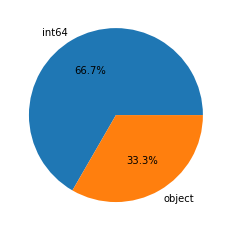

In [166]:
# Types des variables
outils_data.get_types_variables(bureau_balance, True, False, True)

In [167]:
bureau_balance =\
    outils_preprocessing.reduce_mem_usage(bureau_balance, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 624.85 MB
Memory usage après optimization: 338.46 MB
Diminution de 45.8%
-------------------------------------------------------------------------------


#### <span style='background:Moccasin'>5.1.2. Valeurs manquantes</span>

In [168]:
# Valeurs manquantes du dataframe
df_nan_bal = outils_data.get_missing_values(bureau_balance,
                                            True, False, True)

Valeurs manquantes : 0 NaN pour 81899775 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



,Nombres de valeurs manquantes,% de valeurs manquantes


Aucune valeurs manquantes ==> aucune imputation a effectuer.

#### <span style='background:Moccasin'>5.1.3. Feature engineering</span>

[Source](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

 <span style='background:Plum'>**Variables métiers**</span>

**MONTHS_BALANCE**

D'après les statistiques, les valeurs sont négatives (-x mois), elles seront converties positivement.

In [169]:
# Rendre le nombre de mois positif
bureau_balance['MONTHS_BALANCE'] = \
       np.abs(bureau_balance['MONTHS_BALANCE'])

**STATUS**

Statut du prêt du Credit Bureau durant le mois (actif ou fermé ou DPD0-30...) :
- C => fermé
- X => statut inconnu
- 0 => pas de DPD
- 1 => DPD maximal durant le mois entre 1-30
- 2 signifie DPD 31-60
- ../.
- 5 ==> DPD 120+ ou vendu ou amorti ]

L'encodage consistera à donner à la valeur 0 puis d'incrémenter les valeurs, en plaçant X, la valeur inconnue au milieu du tableau des valeurs en lui donnant le bénéfice du doute et 0 pour 0 pas de défaillance.

In [170]:
# Encodage status
dict_status = {'C': 0, '0': 0, '1': 1, '2': 2, 'X': 3, '3': 4,
               '4': 5, '5': 6}
bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_status)

**Ratio STATUS/MONTHS_BALANCE**

In [171]:
# Ajout d'une variable du ratio du status par mois
bureau_balance['STATUS_MONTHS_RATIO'] = bureau_balance.STATUS / \
    (bureau_balance.MONTHS_BALANCE + 1)

 <span style='background:Plum'>**Variables statistiques automatiques**</span>

Création des variables statistiques mean, max, min, last, first...

In [172]:
%pycodestyle_off

**Variables quantitatives**

In [173]:
# Ajout des variables de statistiques
dico_agg_bal = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'sum'],
                'STATUS': ['max', 'mean', 'last','sum'],
                'STATUS_MONTHS_RATIO' : ['mean', 'sum', 'last']}

agg_bureau_balance_num = \
    outils_preprocessing.agg_var_num(bureau_balance, 'SK_ID_BUREAU',
                                     dico_agg_bal, 'BUREAU_BALANCE')
print(f'{agg_bureau_balance_num.shape}')
agg_bureau_balance_num.head()

(817395, 12)


,SK_ID_BUREAU,BUREAU_BALANCE_MONTHS_BALANCE_MIN,BUREAU_BALANCE_MONTHS_BALANCE_MAX,BUREAU_BALANCE_MONTHS_BALANCE_MEAN,BUREAU_BALANCE_MONTHS_BALANCE_SUM,BUREAU_BALANCE_STATUS_MAX,BUREAU_BALANCE_STATUS_MEAN,BUREAU_BALANCE_STATUS_LAST,BUREAU_BALANCE_STATUS_SUM,BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN,BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM,BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST
0,5001709,0,96,48.0,4656.0,3,0.3402,3,33,0.0037,0.3591,0.0309
1,5001710,0,82,41.0,3403.0,3,1.0843,3,90,0.0161,1.3399,0.0361
2,5001711,0,3,1.5,6.0,3,0.7500,0,3,0.7500,3.0000,0.0000
3,5001712,0,18,9.0,171.0,0,0.0000,0,0,0.0000,0.0000,0.0000
4,5001713,0,21,10.5,231.0,3,3.0000,3,66,0.5033,11.0724,0.1364


In [174]:
# Valeurs manquantes ?
outils_data.get_missing_values(agg_bureau_balance_num, False, False, False)

Valeurs manquantes : 0 NaN pour 9808740 données (0.0 %)


In [175]:
# Réduction de l'utilisation de la mémoire
agg_bureau_balance_num =\
    outils_preprocessing.reduce_mem_usage(agg_bureau_balance_num,
                                          verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 63.92 MB
Memory usage après optimization: 17.15 MB
Diminution de 73.2%
-------------------------------------------------------------------------------


In [176]:
# Ajout de la clé d'identification du demandeur
df_cle_demandeur = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']]
bureau_balance_par_demandeur = df_cle_demandeur.merge(agg_bureau_balance_num,
                                                      on='SK_ID_BUREAU',
                                                      how='left')
print(bureau_balance_par_demandeur.shape)
bureau_balance_par_demandeur.head()

(1716428, 13)


,SK_ID_CURR,SK_ID_BUREAU,BUREAU_BALANCE_MONTHS_BALANCE_MIN,BUREAU_BALANCE_MONTHS_BALANCE_MAX,BUREAU_BALANCE_MONTHS_BALANCE_MEAN,BUREAU_BALANCE_MONTHS_BALANCE_SUM,BUREAU_BALANCE_STATUS_MAX,BUREAU_BALANCE_STATUS_MEAN,BUREAU_BALANCE_STATUS_LAST,BUREAU_BALANCE_STATUS_SUM,BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN,BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM,BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST
0,215354,5714462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Un demandeur peut avoir plusieurs prêts contractés auprès de Home Crédit Group (SK_ID_CURR) et peut avoir plusieurs prêts chez un autres organismes identifiés par SK_ID_BUREAU donc un SK_ID_CURR peut avoir 0 ou plusieurs SK_ID_BUREAU.
- La moyenne des différents autres prêts sera effectuée pour obtenir une seule ligne pour le prêt SK_ID_CURR.

In [177]:
# Aggrégation des autres prêts par la moyenne des données pour chaque SK_ID_CURR
agg_bureau_balance_par_demandeur = \
    outils_preprocessing.agg_moy_par_pret(bureau_balance_par_demandeur.drop(columns=['SK_ID_BUREAU']),
                                          'SK_ID_CURR', 'PKPRET')
print(agg_bureau_balance_par_demandeur.shape)
agg_bureau_balance_par_demandeur.head()

(305811, 12)


,SK_ID_CURR,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_mean,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_mean,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_mean,PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_SUM_mean,PKPRET_BUREAU_BALANCE_STATUS_MAX_mean,PKPRET_BUREAU_BALANCE_STATUS_MEAN_mean,PKPRET_BUREAU_BALANCE_STATUS_LAST_mean,PKPRET_BUREAU_BALANCE_STATUS_SUM_mean,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_mean,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM_mean,PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_mean
0,100001,0.0,23.5714,11.7891,400.0000,2.1429,0.6514,1.7143,13.0,0.1381,0.9395,0.2522
1,100002,15.5,28.2500,21.8750,337.5000,2.3750,0.7417,2.2500,9.0,0.0732,0.4834,0.1433
2,100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,0.0,6.0000,3.0000,30.3281,2.0000,0.4102,1.0000,2.0,0.3394,1.0771,0.0769


**Sauvegarde**

In [178]:
# Sauvegarde de agg_bureau_balance_num
fic_sav_agg_bureau_balance_num = \
    '../sauvegarde/pre-processing/agg_bureau_balance_num.pickle'
with open(fic_sav_agg_bureau_balance_num, 'wb') as f:
    pickle.dump(agg_bureau_balance_par_demandeur, f, pickle.HIGHEST_PROTOCOL)
agg_bureau_balance_par_demandeur.shape

(305811, 12)

**Chargement**

In [39]:
# Chargement de agg_bureau_balance_num
fic_sav_agg_bureau_balance_num = \
    '../sauvegarde/pre-processing/agg_bureau_balance_num.pickle'
with open(fic_sav_agg_bureau_balance_num, 'rb') as df_agg_bureau_balance_num:
    agg_bureau_balance_par_demandeur = pickle.load(df_agg_bureau_balance_num)
agg_bureau_balance_par_demandeur.shape

(305811, 12)

#### <span style='background:Moccasin'>5.1.4. Assemblage avec le 'train set'</span>

In [43]:
# Dimensions avant merge
print(f'application_train : {application_train.shape}')
print(f'appli_train_imp1 : {appli_train_imp1.shape}')
print(f'appli_train_imp2 : {appli_train_imp2.shape}')
df = agg_bureau_balance_par_demandeur
print(f'agg_bureau_balance_par_demandeur : {df.shape}')

application_train : (307507, 206)
appli_train_imp1 : (307507, 213)
appli_train_imp2 : (307507, 207)
agg_bureau_balance_par_demandeur : (305811, 12)


In [44]:
# Merge variables numérique
# application_train
train_set = application_train.merge(agg_bureau_balance_par_demandeur,
                                    on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')
# appli_train_imp1
train_imp1_set = appli_train_imp1.merge(agg_bureau_balance_par_demandeur,
                                        on='SK_ID_CURR', how='left')
print(f'train_imp1_set : {train_imp1_set.shape}')
# appli_train_imp2
train_imp2_set = appli_train_imp2.merge(agg_bureau_balance_par_demandeur,
                                        on='SK_ID_CURR', how='left')
print(f'train_imp2_set : {train_imp2_set.shape}')

train_set : (307507, 217)
train_imp1_set : (307507, 224)
train_imp2_set : (307507, 218)


In [58]:
# Description
outils_data.description_variables(train_set)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,...,BUREAU_CREDIT_TYPE_Car loan_count,BUREAU_CREDIT_TYPE_Car loan_mean,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_sum,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_count,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_mean,BUREAU_CREDIT_TYPE_Consumer credit_sum,BUREAU_CREDIT_TYPE_Consumer credit_count,BUREAU_CREDIT_TYPE_Consumer credit_mean,BUREAU_CREDIT_TYPE_Credit card_sum,BUREAU_CREDIT_TYPE_Credit card_count,BUREAU_CREDIT_TYPE_Credit card_mean,BUREAU_CREDIT_TYPE_Interbank credit_sum,BUREAU_CREDIT_TYPE_Interbank credit_count,BUREAU_CREDIT_TYPE_Interbank credit_mean,BUREAU_CREDIT_TYPE_Loan for business development_sum,BUREAU_CREDIT_TYPE_Loan for business development_count,BUREAU_CREDIT_TYPE_Loan for business development_mean,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_sum,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_count,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_mean,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_sum,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_count,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_mean,BUREAU_CREDIT_TYPE_Microloan_sum,BUREAU_CREDIT_TYPE_Microloan_count,BUREAU_CREDIT_TYPE_Microloan_mean,BUREAU_CREDIT_TYPE_Mobile operator loan_sum,BUREAU_CREDIT_TYPE_Mobile operator loan_count,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mortgage_sum,BUREAU_CREDIT_TYPE_Mortgage_count,BUREAU_CREDIT_TYPE_Mortgage_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,BUREAU_CREDIT_TYPE_Real estate loan_count,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Unknown type of loan_sum,BUREAU_CREDIT_TYPE_Unknown type of loan_count,BUREAU_CREDIT_TYPE_Unknown type of loan_mean,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_LAST,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_

#### <span style='background:Moccasin'>5.1.5. Assemblage avec le 'test set'</span>

In [48]:
# Dimensions avant merge
print(f'application_test : {application_test.shape}')
print(f'appli_test_imp1 : {appli_test_imp1.shape}')
print(f'appli_test_imp2 : {appli_test_imp2.shape}')
df = agg_bureau_balance_par_demandeur
print(f'agg_bureau_balance_par_demandeur : {df.shape}')

application_test : (48744, 205)
appli_test_imp1 : (48744, 212)
appli_test_imp2 : (48744, 206)
agg_bureau_balance_par_demandeur : (305811, 12)


In [49]:
# Merge variables numériques
test_set = application_test.merge(agg_bureau_balance_par_demandeur,
                                  on='SK_ID_CURR', how='left')
print(f'test_set : {test_set.shape}')
test_imp1_set = appli_test_imp1.merge(agg_bureau_balance_par_demandeur,
                                      on='SK_ID_CURR', how='left')
print(f'test_imp1_set : {test_imp1_set.shape}')
test_imp2_set = appli_test_imp2.merge(agg_bureau_balance_par_demandeur,
                                      on='SK_ID_CURR', how='left')
print(f'test_imp2_set : {test_imp2_set.shape}')

test_set : (48744, 216)
test_imp1_set : (48744, 223)
test_imp2_set : (48744, 217)


In [57]:
# Description
outils_data.description_variables(test_set)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,...,BUREAU_CREDIT_TYPE_Car loan_count,BUREAU_CREDIT_TYPE_Car loan_mean,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_sum,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_count,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_mean,BUREAU_CREDIT_TYPE_Consumer credit_sum,BUREAU_CREDIT_TYPE_Consumer credit_count,BUREAU_CREDIT_TYPE_Consumer credit_mean,BUREAU_CREDIT_TYPE_Credit card_sum,BUREAU_CREDIT_TYPE_Credit card_count,BUREAU_CREDIT_TYPE_Credit card_mean,BUREAU_CREDIT_TYPE_Interbank credit_sum,BUREAU_CREDIT_TYPE_Interbank credit_count,BUREAU_CREDIT_TYPE_Interbank credit_mean,BUREAU_CREDIT_TYPE_Loan for business development_sum,BUREAU_CREDIT_TYPE_Loan for business development_count,BUREAU_CREDIT_TYPE_Loan for business development_mean,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_sum,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_count,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_mean,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_sum,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_count,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_mean,BUREAU_CREDIT_TYPE_Microloan_sum,BUREAU_CREDIT_TYPE_Microloan_count,BUREAU_CREDIT_TYPE_Microloan_mean,BUREAU_CREDIT_TYPE_Mobile operator loan_sum,BUREAU_CREDIT_TYPE_Mobile operator loan_count,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mortgage_sum,BUREAU_CREDIT_TYPE_Mortgage_count,BUREAU_CREDIT_TYPE_Mortgage_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,BUREAU_CREDIT_TYPE_Real estate loan_count,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Unknown type of loan_sum,BUREAU_CREDIT_TYPE_Unknown type of loan_count,BUREAU_CREDIT_TYPE_Unknown type of loan_mean,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_LAST,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_DAY

### <span style='background:PowderBlue'>5.2. Fichiers bureau.csv</span>

| Fichier | Description |
| --- | --- |
|  <p style='text-align: justify;'>**bureau.csv** |  <ul style='text-align: justify;'><li>Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau (pour les clients qui ont un prêt dans notre échantillon). </li> <li> Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande.</li> |

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <ul style='text-align: left;'><li>ID du prêt dans notre échantillon</li> <li>Un prêt dans notre échantillon peut avoir 0, 1, 2 ou plus de crédits précédents liés dans le bureau de crédit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_BUREAU_ID**</p> | <p style='text-align: justify;'>ID recodé du crédit précédent du Credit Bureau lié à notre prêt (codage unique pour chaque demande de prêt)</p> |  |
| <p style='text-align: justify;'>**CREDIT_ACTIVE**</p> | <p style='text-align: justify;'>Statut des crédits déclarés par le Credit Bureau (CB)</p> | <ul style='text-align: justify;'><li>Closed</li> <li>Active</li> <li>Sold</li> <li>Bad debt</li></ul> |
| <p style='text-align: justify;'>**CREDIT_CURRENCY**</p> | <p style='text-align: justify;'>Devise recodée du crédit du Credit Bureau</p> | <ul style='text-align: justify;'><li>currency 1</li> <li>currency 2</li> <li>currency 3</li> <li>currency 4</li></ul>  |
| <p style='text-align: justify;'>**DAYS_CREDIT**</p> | <p style='text-align: justify;'>Combien de jours avant la demande actuelle le client a-t-il demandé un crédit au Credit Bureau ?</p> |  |
| <p style='text-align: justify;'>**CREDIT_DAY_OVERDUE**</p> | <p style='text-align: justify;'>Nombre de jours de retard sur le crédit CB au moment de la demande de prêt liée à notre échantillon.</p> |  |
| <p style='text-align: justify;'>**DAYS_CREDIT_ENDDATE**</p> | <p style='text-align: justify;'>Durée restante du crédit CB (en jours) au moment de la demande dans Crédit immobilier</p> |  |
| <p style='text-align: justify;'>**DAYS_ENDDATE_FACT**</p> | <p style='text-align: justify;'>Jours depuis la fin du crédit CB au moment de la demande dans le crédit domestique (uniquement pour les crédits fermés).</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_MAX_OVERDUE**</p> | <p style='text-align: justify;'>Montant maximal des impayés sur le crédit du Credit Bureau jusqu'à présent (à la date de demande du prêt dans notre échantillon).</p> |  |
| <p style='text-align: justify;'>**CNT_CREDIT_PROLONG**</p> | <p style='text-align: justify;'>Combien de fois le crédit du Bureau de crédit a-t-il été prolongé ?</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_SUM**</p> | <p style='text-align: justify;'>Montant actuel du crédit du Credit Bureau.</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_SUM_DEBT**</p> | <p style='text-align: justify;'>Dette actuelle sur le crédit du Credit Bureau.</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_SUM_LIMIT**</p> | <p style='text-align: justify;'>Limite de crédit actuelle de la carte de crédit déclarée dans le Bureau de crédit.</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_SUM_OVERDUE**</p> | <p style='text-align: justify;'>Montant actuel en retard sur le crédit du Bureau de crédit.</p> |  |
| <p style='text-align: justify;'>**CREDIT_TYPE**</p> | <p style='text-align: justify;'>Type de crédit du Bureau de crédit (voiture ou argent liquide...)</p> | <ul style='text-align: justify;'><li>Credit card</li> <li>Consumer credit</li> <li>Loan for business development</li> <li>Microloan</li> <li>Mortgage</li> <li>Car loan</li> <li>Loan for working capital replenishment</li> <li>Another type of loan</li> <li>Unknown type of loan</li> <li>Loan for the purchase of equipment</li> <li>Cash loan (non-earmarked)</li> <li>Real estate loan</li> <li>Interbank credit</li> <li>Loan for purchase of shares (margin lending)</li> <li>Mobile operator loan</li></ul> |
| <p style='text-align: justify;'>**DAYS_CREDIT_UPDATE**</p> | <p style='text-align: justify;'>Combien de jours avant la demande de prêt la dernière information sur la solvabilité du Credit Bureau a-t-elle été fournie ?</p> |  |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuité du crédit du Credit Bureau	</p> |  |

In [216]:
# Taille : nombre de lignes/colonnes
nRow, nVar = bureau.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1716428 lignes et 17 variables.


In [217]:
# Variables quantitatives
cols_num_bur = bureau.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_bur

['SK_ID_CURR',
 'SK_ID_BUREAU',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY']

In [218]:
# Variables catégorielles
cols_cat_bur = bureau.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_bur

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

In [219]:
# Résumé des variables
desc_bureau = outils_data.description_variables(bureau)
desc_bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
type,int64,int64,object,object,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,object,int64,float64
nb_nan,0.0,0.0,0.0,0.0,0.0,0.0,105553.0,633653.0,1124488.0,0.0,13.0,257669.0,591780.0,0.0,0.0,0.0,1226791.0
%_nan,0.0,0.0,0.0,0.0,0.0,0.0,0.3617,2.1716,3.8537,0.0,0.0,0.8831,2.0281,0.0,0.0,0.0,4.2043
count,1716428.0,1716428.0,1716428,1716428,1716428.0,1716428.0,1610875.0,1082775.0,591940.0,1716428.0,1716415.0,1458759.0,1124648.0,1716428.0,1716428,1716428.0,489637.0
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,278214.9336,5924434.489,NaN,NaN,-1142.1077,0.8182,510.5174,-1017.4371,3825.4177,0.0064,354994.5919,137085.12,6229.515,37.9128,NaN,-593.7483,15712.7577
std,102938.5581,532265.7286,NaN,NaN,795.1649,36.5444,4994.2198,714.0106,206031.6062,0.0962,1149811.344,677401.131,45032.0315,5937.65,NaN,720.7473,325826.9491
min,100001.0,5000000.0,NaN,NaN,-2922.0,0.0,-42060.0,-42023.0,0.0,0.0,0.0,-4705600.32,-586406.115,0.0,NaN,-41947.0,0.0


Toutes les variables de type date en jours ont des valeurs > 115 ans qui pour une durée de prêt dépasse l'espérance de vie comme nous l'avions vu lors de l'analyse exploratoire.

#### <span style='background:Moccasin'>5.2.1. Types des objets</span>

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

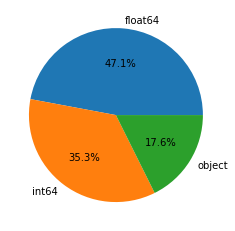

In [220]:
# Types des variables
outils_data.get_types_variables(bureau, True, False, True)

In [221]:
bureau = outils_preprocessing.reduce_mem_usage(bureau, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 222.62 MB
Memory usage après optimization: 112.95 MB
Diminution de 49.3%
-------------------------------------------------------------------------------


#### <span style='background:Moccasin'>5.2.2. Valeurs aberrantes</span>

Lors de l'analyse exploratoire, nous avons rencontré le problème pour les variables avec un nombre de jours qui remonte à plus de 115 ans :
- DAYS_CREDIT_ENDDATE,
- DAYS_ENDDATE_FACT,
- et DAYS_CREDIT_UPDATE.

Nous conserverons les valeurs pour lesquels le prêt remonte à 80 ans, ce qui est humainement possible si le prêt est pris à la majorité avec une espérance de vie de 100 ans.

**DAYS_CREDIT_ENDDATE**

In [222]:
# Suppression des valeurs remontant à plus de 80 ans
bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] > -80*365] = np.nan

**DAYS_ENDDATE_FACT**

In [223]:
# Suppression des valeurs remontant à plus de 80 ans
bureau['DAYS_ENDDATE_FACT'][bureau['DAYS_ENDDATE_FACT'] > -80*365] = np.nan

**DAYS_CREDIT_UPDATE**

In [224]:
# Suppression des valeurs remontant à plus de 80 ans
bureau['DAYS_CREDIT_UPDATE'][bureau['DAYS_CREDIT_UPDATE'] > -80*365] = np.nan

#### <span style='background:Moccasin'>5.2.3. Feature engineering</span>

[Source](https://github.com/rishabhrao1997/Home-Credit-Default-Risk)

 <span style='background:Plum'>**Variables métiers**</span>

In [17]:
# Durée du crédit
bureau['CREDIT_DURATION'] = \
    np.abs(bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE'])

# Retard sur le crédit
bureau['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1
                                 for ele in bureau['CREDIT_DAY_OVERDUE']]

# Ratio : Montant maximal des impayés sur le crédit du Credit Bureau jusqu'à
#         présent (à la date de demande du prêt dans notre échantillon) \
#         Durée du crédit
bureau['MAX_AMT_OVERDUE_DURATION_RATIO'] = \
    bureau['AMT_CREDIT_MAX_OVERDUE'] / (bureau['CREDIT_DURATION'] + 0.00001)
# Ratio : Montant actuel en retard sur le crédit du Bureau de crédit \
#         Durée du crédit
bureau['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = \
    bureau['AMT_CREDIT_SUM_OVERDUE'] / (bureau['CREDIT_DURATION'] + 0.00001)
# Ratio : Montant actuel en retard sur le crédit du Bureau de crédit \
#         Durée restante du crédit CB (en jours)
bureau['AMT_OVERDUE_DURATION_LEFT_RATIO'] = \
    bureau['AMT_CREDIT_SUM_OVERDUE'] / (bureau['DAYS_CREDIT_ENDDATE']
                                        + 0.00001)
# Ratio : Nombre de fois où le crédit du Bureau de crédit a été prolongé \
#         Durée restante du crédit CB (en jours)
bureau['CNT_PROLONGED_MAX_OVERDUE_MUL'] = \
    bureau['CNT_CREDIT_PROLONG'] * bureau['AMT_CREDIT_MAX_OVERDUE']
# Ratio : Nombre de fois où le crédit du Bureau de crédit a été prolongé \
#         Montant maximal des impayés sur le crédit
bureau['CNT_PROLONGED_DURATION_RATIO'] = \
    bureau['CNT_CREDIT_PROLONG'] / (bureau['CREDIT_DURATION'] + 0.00001)
# Ratio : Dette actuelle sur le crédit \
#         Limite de crédit actuelle de la carte de crédit
bureau['CURRENT_DEBT_TO_CREDIT_RATIO'] = \
    bureau['AMT_CREDIT_SUM_DEBT'] / (bureau['AMT_CREDIT_SUM'] + 0.00001)
# Ratio : Annuité du crédit \
#         Limite de crédit actuelle de la carte de crédit
bureau['AMT_ANNUITY_CREDIT_RATIO'] = \
    bureau['AMT_ANNUITY'] / (bureau['AMT_CREDIT_SUM'] + 0.00001)


# Différence :  Limite de crédit actuelle de la carte de crédit -
#               Dette actuelle sur le crédit
bureau['CURRENT_CREDIT_DEBT_DIFF'] = \
    bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
# Différence : nombre de jours avant la demande de prêt où la dernière
#              information sur la solvabilité du Credit Bureau a été fournie -
#              Durée restante du crédit CB (en jours)
bureau['CREDIT_ENDDATE_UPDATE_DIFF'] = \
    np.abs(bureau['DAYS_CREDIT_UPDATE'] - bureau['DAYS_CREDIT_ENDDATE'])

 <span style='background:Plum'>**Variables statistiques automatiques**</span>

Création des variables statistiques mean, max, min, last, first...

***
**Variables quantitatives**
***

In [18]:
# Ajout des variables de statistiques
dico_agg_bur = {'DAYS_CREDIT' : ['mean', 'min', 'max', 'last'],
                'CREDIT_DAY_OVERDUE' : ['mean', 'max'],
                'DAYS_CREDIT_ENDDATE' : ['mean', 'min', 'max'],
                'DAYS_ENDDATE_FACT' : ['mean', 'min', 'var'],
                'AMT_CREDIT_MAX_OVERDUE': ['max', 'sum'],
                'CNT_CREDIT_PROLONG': ['max', 'sum'],
                'AMT_CREDIT_SUM' : ['mean', 'sum', 'max'],
                'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
                'AMT_CREDIT_SUM_LIMIT': ['mean', 'max', 'sum'],
                'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max', 'sum'],
                'DAYS_CREDIT_UPDATE' : ['mean', 'min'],
                'AMT_ANNUITY' : ['mean', 'sum', 'min', 'max', 'count', 'var'],
                'CREDIT_DURATION' : ['min', 'max', 'mean'],
                'FLAG_OVERDUE_RECENT': ['count', 'sum'],
                'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max', 'sum'],
                'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max', 'sum'],
                'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max',  'mean'],
                'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean', 'max'],
                'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                'CURRENT_CREDIT_DEBT_DIFF' : ['mean', 'min'],
                'AMT_ANNUITY_CREDIT_RATIO' : ['mean', 'min', 'max'],
                'CREDIT_ENDDATE_UPDATE_DIFF' : ['max', 'min']}
%pycodestyle_off
agg_bureau_num = \
    outils_preprocessing.agg_var_num(bureau.drop(columns=['SK_ID_BUREAU']),
                                     'SK_ID_CURR', dico_agg_bur, 'BUREAU')
%pycodestyle_on
print(f'{agg_bureau_num.shape}')
agg_bureau_num.head()

(305811, 60)


,SK_ID_CURR,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_LAST,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_ENDDATE_FACT_MEAN,BUREAU_DAYS_ENDDATE_FACT_MIN,BUREAU_DAYS_ENDDATE_FACT_VAR,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,BUREAU_CNT_CREDIT_PROLONG_MAX,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_MAX,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_SUM,BUREAU_AMT_ANNUITY_MIN,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_COUNT,BUREAU_AMT_ANNUITY_VAR,BUREAU_CREDIT_DURATION_MIN,BUREAU_CREDIT_DURATION_MAX,BUREAU_CREDIT_DURATION_MEAN,BUREAU_FLAG_OVERDUE_RECENT_COUNT,BUREAU_FLAG_OVERDUE_RECENT_SUM,BUREAU_MAX_AMT_OVERDUE_DURATION_RATIO_MAX,BUREAU_MAX_AMT_OVERDUE_DURATION_RATIO_SUM,BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_MAX,BUREAU_CURRENT_AMT_OVERDUE_DURATION_RATIO_SUM,BUREAU_AMT_OVERDUE_DURATION_LEFT_RATIO_MAX,BUREAU_AMT_OVERDUE_DURATION_LEFT_RATIO_MEAN,BUREAU_CNT_PROLONGED_MAX_OVERDUE_MUL_MEAN,BUREAU_CNT_PROLONGED_MAX_OVERDUE_MUL_MAX,BUREAU_CNT_PROLONGED_DURATION_RATIO_MEAN,BUREAU_CNT_PROLONGED_DURATION_RATIO_MAX,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN,BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MIN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN,BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MEAN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MIN,BUREAU_AMT_ANNUITY_CREDIT_RATIO_MAX,BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MAX,BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MIN
0,100001,-735.0000,-1572,-49,-320,0.0,0,82.4286,-1329.0,1778.0,-825.5000,-1328.0,136219.0000,NaN,0.000,0,0,207623.5714,1.4534e+06,378000.0,85240.9286,596686.5,0.0000,0.000,0.000,0.0,0.0,0.0,-93.1429,-155,3545.3571,24817.5,0.0,10822.5,7,2.3046e+07,243.0,1827.0,817.4286,7,0,NaN,0.0000,0.0,0.0,-0.0,0.0,NaN,NaN,0.0,0.0,0.2825,0.0,122382.6429,4761.0,0.0140,0.0,0.0556,1794.0,24.0
1,100002,-874.0000,-1437,-103,-1043,0.0,0,-349.0000,-1072.0,780.0,-697.5000,-1185.0,266248.3000,5043.645,8405.145,0,0,108131.9456,8.6506e+05,450000.0,49156.2000,245781.0,7997.1412,31988.565,31988.565,0.0,0.0,0.0,-499.8750,-1185,0.0000,0.0,0.0,0.0,7,0.0000e+00,87.0,1822.0,719.8333,8,0,15.8143,22.7234,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.1092,0.0,98388.5130,0.0,0.0000,0.0,0.0000,820.0,0.0
2,100003,-1400.7500,-2586,-606,-606,0.0,0,-544.5000,-2434.0,1216.0,-1097.3333,-2131.0,802990.3333,0.000,0.000,0,0,254350.1250,1.0174e+06,810000.0,0.0000,0.0,202500.0000,810000.000,810000.000,0.0,0.0,0.0,-816.0000,-2131,NaN,0.0,NaN,NaN,0,NaN,152.0,1822.0,856.2500,4,0,0.0000,0.0000,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,254350.1250,22248.0,NaN,NaN,NaN,1259.0,0.0
3,100004,-867.0000,-1326,-408,-408,0.0,0,-488.5000,-595.0,-382.0,-532.5000,-683.0,45300.5000,0.000,0.000,0,0,94518.9000,1.8904e+05,94537.8,0.0000,0.0,0.0000,0.000,0.000,0.0,0.0,0.0,-532.0000,-682,NaN,0.0,NaN,NaN,0,NaN,26.0,731.0,378.5000,2,0,0.0000,0.0000,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,94518.9000,94500.0,NaN,NaN,NaN,87.0,0.0
4,100005,-190.6667,-373,-62,-62,0.0,0,439.3333,-128.0,1324.0,-123.0000,-123.0,NaN,0.000,0.000,0,0,219042.0000,6.5713e+05,568800.0,189469.5000,568408.5,0.0000,0.000,0.000,0.0,0.0,0.0,-54.3333,-121,1420.5000,4261.5,0.0,4261.5,3,6.0535e+06,184.0,1461.0,630.0000,3,0,0.0000,0.0000,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.6013,0.0,29572.5000,4504.5,0.0476,0.0,0.1429,1335.0,7.0


**Sauvegarde**

In [19]:
# Sauvegarde de agg_bureau_num
fic_sav_agg_bureau_num = \
    '../sauvegarde/pre-processing/agg_bureau_num.pickle'
with open(fic_sav_agg_bureau_num, 'wb') as f:
    pickle.dump(agg_bureau_num, f, pickle.HIGHEST_PROTOCOL)
agg_bureau_num.shape

(305811, 60)

**Chargement**

In [40]:
# Chargement de agg_bureau_num
fic_sav_agg_bureau_num = \
    '../sauvegarde/pre-processing/agg_bureau_num.pickle'
with open(fic_sav_agg_bureau_num, 'rb') as df_agg_bureau_num:
    agg_bureau_num = pickle.load(df_agg_bureau_num)
agg_bureau_num.shape

(305811, 60)

***
**Variables qualititatives**
***

In [21]:
agg_bureau_cat = outils_preprocessing.agg_var_cat(bureau, 'SK_ID_CURR',
                                                  'BUREAU')
print(f'{agg_bureau_cat.shape}')
agg_bureau_cat.head()

(305811, 69)


,BUREAU_CREDIT_ACTIVE_Active_sum,BUREAU_CREDIT_ACTIVE_Active_count,BUREAU_CREDIT_ACTIVE_Active_mean,BUREAU_CREDIT_ACTIVE_Bad debt_sum,BUREAU_CREDIT_ACTIVE_Bad debt_count,BUREAU_CREDIT_ACTIVE_Bad debt_mean,BUREAU_CREDIT_ACTIVE_Closed_sum,BUREAU_CREDIT_ACTIVE_Closed_count,BUREAU_CREDIT_ACTIVE_Closed_mean,BUREAU_CREDIT_ACTIVE_Sold_sum,BUREAU_CREDIT_ACTIVE_Sold_count,BUREAU_CREDIT_ACTIVE_Sold_mean,BUREAU_CREDIT_CURRENCY_currency 1_sum,BUREAU_CREDIT_CURRENCY_currency 1_count,BUREAU_CREDIT_CURRENCY_currency 1_mean,BUREAU_CREDIT_CURRENCY_currency 2_sum,BUREAU_CREDIT_CURRENCY_currency 2_count,BUREAU_CREDIT_CURRENCY_currency 2_mean,BUREAU_CREDIT_CURRENCY_currency 3_sum,BUREAU_CREDIT_CURRENCY_currency 3_count,BUREAU_CREDIT_CURRENCY_currency 3_mean,BUREAU_CREDIT_CURRENCY_currency 4_sum,BUREAU_CREDIT_CURRENCY_currency 4_count,BUREAU_CREDIT_CURRENCY_currency 4_mean,BUREAU_CREDIT_TYPE_Another type of loan_sum,BUREAU_CREDIT_TYPE_Another type of loan_count,BUREAU_CREDIT_TYPE_Another type of loan_mean,BUREAU_CREDIT_TYPE_Car loan_sum,BUREAU_CREDIT_TYPE_Car loan_count,BUREAU_CREDIT_TYPE_Car loan_mean,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_sum,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_count,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_mean,BUREAU_CREDIT_TYPE_Consumer credit_sum,BUREAU_CREDIT_TYPE_Consumer credit_count,BUREAU_CREDIT_TYPE_Consumer credit_mean,BUREAU_CREDIT_TYPE_Credit card_sum,BUREAU_CREDIT_TYPE_Credit card_count,BUREAU_CREDIT_TYPE_Credit card_mean,BUREAU_CREDIT_TYPE_Interbank credit_sum,BUREAU_CREDIT_TYPE_Interbank credit_count,BUREAU_CREDIT_TYPE_Interbank credit_mean,BUREAU_CREDIT_TYPE_Loan for business development_sum,BUREAU_CREDIT_TYPE_Loan for business development_count,BUREAU_CREDIT_TYPE_Loan for business development_mean,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_sum,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_count,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_mean,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_sum,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_count,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_mean,BUREAU_CREDIT_TYPE_Microloan_sum,BUREAU_CREDIT_TYPE_Microloan_count,BUREAU_CREDIT_TYPE_Microloan_mean,BUREAU_CREDIT_TYPE_Mobile operator loan_sum,BUREAU_CREDIT_TYPE_Mobile operator loan_count,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mortgage_sum,BUREAU_CREDIT_TYPE_Mortgage_count,BUREAU_CREDIT_TYPE_Mortgage_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,BUREAU_CREDIT_TYPE_Real estate loan_count,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Unknown type of loan_sum,BUREAU_CREDIT_TYPE_Unknown type of loan_count,BUREAU_CREDIT_TYPE_Unknown type of loan_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,7,0.4286,0,7,0.0,4,7,0.5714,0,7,0.0,7,7,1.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,7,7,1.0000,0,7,0.0000,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0,0,7,0.0
100002,2,8,0.2500,0,8,0.0,6,8,0.7500,0,8,0.0,8,8,1.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,4,8,0.5000,4,8,0.5000,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0,0,8,0.0
100003,1,4,0.2500,0,4,0.0,3,4,0.7500,0,4,0.0,4,4,1.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,2,4,0.5000,2,4,0.5000,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0,0,4,0.0
100004,0,2,0.0000,0,2,0.0,2,2,1.0000,0,2,0.0,2,2,1.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,2,2,1.0000,0,2,0.0000,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0,0,2,0.0
100005,2,3,0.6667,0,3,0.0,1,3,0.3333,0,3,0.0,3,3,1.0,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,2,3,0.6667,1,3,0.3333,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,0,3,0.0,

**Sauvegarde**

In [22]:
# Sauvegarde de agg_bureau_cat
fic_sav_agg_bureau_cat = \
    '../sauvegarde/pre-processing/agg_bureau_cat.pickle'
with open(fic_sav_agg_bureau_cat, 'wb') as f:
    pickle.dump(agg_bureau_cat, f, pickle.HIGHEST_PROTOCOL)
agg_bureau_cat.shape

(305811, 69)

**Chargement**

In [41]:
# Chargement de agg_bureau_cat
fic_sav_agg_bureau_cat = \
    '../sauvegarde/pre-processing/agg_bureau_cat.pickle'
with open(fic_sav_agg_bureau_cat, 'rb') as df_agg_bureau_cat:
    agg_bureau_cat = pickle.load(df_agg_bureau_cat)
agg_bureau_cat.shape

(305811, 69)

#### <span style='background:Moccasin'>5.2.4. Assemblage avec le 'train set'</span>

In [45]:
# Dimensions avant merge
print(f'train_set : {train_set.shape}')
print(f'train_imp1_set : {train_imp1_set.shape}')
print(f'train_imp2_set : {train_imp2_set.shape}')
print(f'agg_bureau_cat : {agg_bureau_cat.shape}')
print(f'agg_bureau_num : {agg_bureau_num.shape}')

train_set : (307507, 217)
train_imp1_set : (307507, 224)
train_imp2_set : (307507, 218)
agg_bureau_cat : (305811, 69)
agg_bureau_num : (305811, 60)


In [46]:
# Merge variables catégorielles
train_set = train_set.merge(agg_bureau_cat, on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')
train_imp1_set = train_imp1_set.merge(agg_bureau_cat, on='SK_ID_CURR',
                                      how='left')
print(f'train_imp1_set : {train_imp1_set.shape}')
train_imp2_set = train_imp2_set.merge(agg_bureau_cat, on='SK_ID_CURR',
                                      how='left')
print(f'train_imp2_set : {train_imp2_set.shape}')

train_set : (307507, 286)
train_imp1_set : (307507, 293)
train_imp2_set : (307507, 287)


In [47]:
# Merge variables numériques
train_set = train_set.merge(agg_bureau_num, on='SK_ID_CURR', how='left')
print(f'train_set : {train_set.shape}')
train_imp1_set = train_imp1_set.merge(agg_bureau_num, on='SK_ID_CURR',
                                      how='left')
print(f'train_imp1_set : {train_imp1_set.shape}')
train_imp2_set = train_imp2_set.merge(agg_bureau_num, on='SK_ID_CURR',
                                      how='left')
print(f'train_imp2_set : {train_imp2_set.shape}')

train_set : (307507, 345)
train_imp1_set : (307507, 352)
train_imp2_set : (307507, 346)


In [55]:
# Description
outils_data.description_variables(train_set)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,...,BUREAU_CREDIT_TYPE_Car loan_count,BUREAU_CREDIT_TYPE_Car loan_mean,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_sum,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_count,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_mean,BUREAU_CREDIT_TYPE_Consumer credit_sum,BUREAU_CREDIT_TYPE_Consumer credit_count,BUREAU_CREDIT_TYPE_Consumer credit_mean,BUREAU_CREDIT_TYPE_Credit card_sum,BUREAU_CREDIT_TYPE_Credit card_count,BUREAU_CREDIT_TYPE_Credit card_mean,BUREAU_CREDIT_TYPE_Interbank credit_sum,BUREAU_CREDIT_TYPE_Interbank credit_count,BUREAU_CREDIT_TYPE_Interbank credit_mean,BUREAU_CREDIT_TYPE_Loan for business development_sum,BUREAU_CREDIT_TYPE_Loan for business development_count,BUREAU_CREDIT_TYPE_Loan for business development_mean,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_sum,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_count,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_mean,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_sum,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_count,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_mean,BUREAU_CREDIT_TYPE_Microloan_sum,BUREAU_CREDIT_TYPE_Microloan_count,BUREAU_CREDIT_TYPE_Microloan_mean,BUREAU_CREDIT_TYPE_Mobile operator loan_sum,BUREAU_CREDIT_TYPE_Mobile operator loan_count,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mortgage_sum,BUREAU_CREDIT_TYPE_Mortgage_count,BUREAU_CREDIT_TYPE_Mortgage_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,BUREAU_CREDIT_TYPE_Real estate loan_count,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Unknown type of loan_sum,BUREAU_CREDIT_TYPE_Unknown type of loan_count,BUREAU_CREDIT_TYPE_Unknown type of loan_mean,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_LAST,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_

#### <span style='background:Moccasin'>5.2.5. Assemblage avec le 'test set'</span>

In [50]:
# Dimensions avant merge
print(f'test_set : {test_set.shape}')
print(f'test_imp1_set : {test_imp1_set.shape}')
print(f'test_imp2_set : {test_imp2_set.shape}')
print(f'agg_bureau_cat : {agg_bureau_cat.shape}')
print(f'agg_bureau_num : {agg_bureau_num.shape}')

test_set : (48744, 216)
test_imp1_set : (48744, 223)
test_imp2_set : (48744, 217)
agg_bureau_cat : (305811, 69)
agg_bureau_num : (305811, 60)


In [51]:
# Merge variables catégorielles
test_set = test_set.merge(agg_bureau_cat, on='SK_ID_CURR', how='left')
print(f'test_set  : {test_set.shape}')
test_imp1_set = test_imp1_set.merge(agg_bureau_cat, on='SK_ID_CURR',
                                    how='left')
print(f'test_imp1_set  : {test_imp1_set.shape}')
test_imp2_set = test_imp2_set.merge(agg_bureau_cat, on='SK_ID_CURR',
                                    how='left')
print(f'test_imp2_set  : {test_imp2_set.shape}')

test_set  : (48744, 285)
test_imp1_set  : (48744, 292)
test_imp2_set  : (48744, 286)


In [52]:
# Merge variables numériques
test_set = test_set.merge(agg_bureau_num, on='SK_ID_CURR', how='left')
print(f'test_set  : {test_set.shape}')
test_imp1_set = test_imp1_set.merge(agg_bureau_num, on='SK_ID_CURR',
                                    how='left')
print(f'test_imp1_set  : {test_imp1_set.shape}')
test_imp2_set = test_imp2_set.merge(agg_bureau_num, on='SK_ID_CURR',
                                    how='left')
print(f'test_imp2_set  : {test_imp2_set.shape}')

test_set  : (48744, 344)
test_imp1_set  : (48744, 351)
test_imp2_set  : (48744, 345)


In [56]:
# Description
outils_data.description_variables(test_set)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,NONLIVINGAREA_AVG,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,INCOME_GOODS_DIFF,INCOME_EXT_RATIO,LAST_PHONE_EMPLOYED_RATIO,CAR_EMPLOYED_RATIO,FLAG_CONTACTS_SUM,CNT_NON_CHILDREN,EXT_SOURCE_SUM,EXT_SOURCE_MAX,EXT_SOURCE_VAR,OBS_DEF_30_MUL,OBS_30_CREDIT_RATIO,FLAGS_DOCUMENTS_SUM,ENQ_CREDIT_RATIO,TARGET_NEIGHBORS_500_MEAN,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,...,BUREAU_CREDIT_TYPE_Car loan_count,BUREAU_CREDIT_TYPE_Car loan_mean,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_sum,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_count,BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_mean,BUREAU_CREDIT_TYPE_Consumer credit_sum,BUREAU_CREDIT_TYPE_Consumer credit_count,BUREAU_CREDIT_TYPE_Consumer credit_mean,BUREAU_CREDIT_TYPE_Credit card_sum,BUREAU_CREDIT_TYPE_Credit card_count,BUREAU_CREDIT_TYPE_Credit card_mean,BUREAU_CREDIT_TYPE_Interbank credit_sum,BUREAU_CREDIT_TYPE_Interbank credit_count,BUREAU_CREDIT_TYPE_Interbank credit_mean,BUREAU_CREDIT_TYPE_Loan for business development_sum,BUREAU_CREDIT_TYPE_Loan for business development_count,BUREAU_CREDIT_TYPE_Loan for business development_mean,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_sum,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_count,BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_mean,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_sum,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_count,BUREAU_CREDIT_TYPE_Loan for working capital replenishment_mean,BUREAU_CREDIT_TYPE_Microloan_sum,BUREAU_CREDIT_TYPE_Microloan_count,BUREAU_CREDIT_TYPE_Microloan_mean,BUREAU_CREDIT_TYPE_Mobile operator loan_sum,BUREAU_CREDIT_TYPE_Mobile operator loan_count,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mortgage_sum,BUREAU_CREDIT_TYPE_Mortgage_count,BUREAU_CREDIT_TYPE_Mortgage_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,BUREAU_CREDIT_TYPE_Real estate loan_count,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Unknown type of loan_sum,BUREAU_CREDIT_TYPE_Unknown type of loan_count,BUREAU_CREDIT_TYPE_Unknown type of loan_mean,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_LAST,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_DAY